In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline
import gc  # garbage collection
from sklearn.cluster import KMeans  # k-means 군집분석
from sklearn.metrics import silhouette_score  # 군집분석 평가를 위한 silhouette 값 계산

pd.set_option('max_columns', 20, 'max_rows', 20)

In [2]:
#matplotlib 한글깨짐 지원
import platform

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False)    

In [3]:
tr = pd.read_csv('data/L사_거래정보.csv')

In [4]:
cu = pd.read_csv('data/L사_고객정보.csv')

In [5]:
go = pd.read_csv('data/L사_상품정보.csv')

In [6]:
tr.info(), cu.info(), go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599961 entries, 0 to 599960
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   clnt_id    599961 non-null  int64 
 1   trans_id   599961 non-null  int64 
 2   trans_seq  599961 non-null  int64 
 3   biz_unit   599961 non-null  object
 4   pd_c       599961 non-null  object
 5   de_dt      599961 non-null  int64 
 6   de_tm      599961 non-null  object
 7   buy_am     599961 non-null  int64 
 8   buy_ct     599961 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 41.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72399 entries, 0 to 72398
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   clnt_id      72399 non-null  int64 
 1   clnt_gender  72399 non-null  object
 2   clnt_age     72399 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
<class 'pandas.core.frame.DataFrame'

(None, None, None)

In [7]:
go.pd_c = go.pd_c.astype(str).str.zfill(4)
tr.de_dt = tr.de_dt.astype(str).astype('datetime64')

df = pd.merge(tr, cu).merge(go, on = 'pd_c')

#del tr, go
#gc.collect()

# Data cleansing

## 이상치 처리

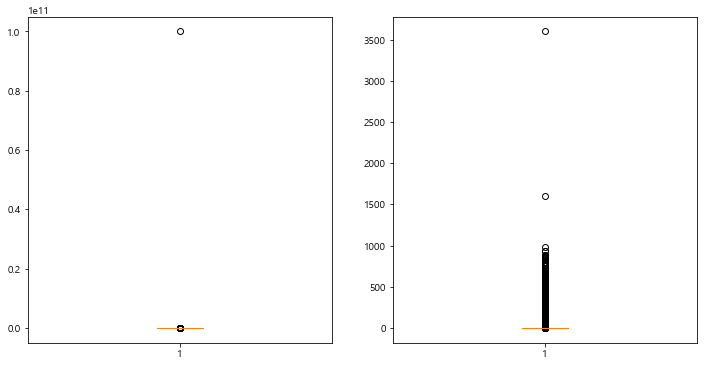

In [8]:
fig, ax = plt.subplots(1, 2, figsize = (12,6))

ax[0].boxplot(df['buy_am'])
ax[1].boxplot(df['buy_ct'])

plt.show()

In [9]:
max_buy_am = df.buy_am.sort_values(ascending = False).iloc[0]
df = df.query('buy_am != @max_buy_am ')

In [10]:
df = df.query('buy_ct < 1300')

### 구매금액이나 구매건수가 잘못되어있는 경우

#### buy_am ==0 이고 buy_ct == 0인 경우

In [11]:
df = df.query('buy_am != 0 or buy_ct != 0')

In [12]:
len(df)

581863

#### buy_am ==0 이고 buy_ct != 0인 경우

In [13]:
df_0n = df.query('buy_am == 0')
df_nn = df.query('buy_am != 0')

In [14]:
# 구매금액이 0인 데이터의 갯수
len(df_0n)

83

In [15]:
# 상품별 구매금액의 합
buy_a = df_nn.groupby('pd_c')[['buy_am']].agg('sum').reset_index()
# 상품별 구매수량의 합
buy_c = df_nn.groupby('pd_c')[['buy_ct']].agg('sum').reset_index()

buy_mer = pd.merge(buy_a, buy_c, on = 'pd_c')

# 상품별 평균 구매금액
buy_mer['buy_mean'] = buy_mer['buy_am']//buy_mer['buy_ct']
del buy_mer['buy_am'], buy_mer['buy_ct']

buy_mer['buy_am'] = buy_mer['buy_mean']
del buy_mer['buy_mean']

In [16]:
# 구매금액이 0인 데이터에서 구매금액 열을 지우고 앞에서 구한 구매금액을 merge
del df_0n['buy_am']

df_0n = pd.merge(df_0n, buy_mer, how='left', on='pd_c')

In [17]:
# 구매금액이 모두 0이어서 평균을 구할 수 없었던 상품이 있었는지 확인
df_0n.isna().sum()

clnt_id         0
trans_id        0
trans_seq       0
biz_unit        0
pd_c            0
de_dt           0
de_tm           0
buy_ct          0
clnt_gender     0
clnt_age        0
clac_nm1        0
clac_nm2        0
clac_nm3        0
buy_am         22
dtype: int64

In [18]:
# 구매금액의 평균을 알 수 없는 상품이 해당 된 행 지우기
df_0n = df_0n.dropna(how='any')

In [19]:
df = pd.concat([df_nn, df_0n]); len(df)

581841

In [20]:
del df_0n, df_nn

#### buy_am != 0 이고 buy_ct == 0인 경우

In [21]:
df_n0 = df.query('buy_ct == 0')
df_nn = df.query('buy_ct != 0')

In [22]:
# 구매수량이 0인 데이터 갯수
len(df_n0)

6255

In [23]:
buy_mer['mean'] = buy_mer['buy_am']

del buy_mer['buy_am']

In [24]:
df_n0 = pd.merge(df_n0, buy_mer, how='left', on='pd_c')

In [25]:
# 구매금액이 평균*수량(j)보다 작거나 같으면 구매수량을 j로 바꿔라
for i in range(len(df_n0)):
    for j in range(1,35):
        if df_n0['buy_am'][i] <= (df_n0['mean'][i]*j):
            df_n0['buy_ct'][i] = j

C:\Users\Yoon Kyung Seo\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [26]:
df_n = df_n0.query('buy_ct != 0')
df_n0 = df_n0.query('buy_ct == 0')

In [27]:
# 수량이 0인 열이 있는지 확인
len(df_n), len(df_n0)

(6255, 0)

In [28]:
del df_n['mean']

In [29]:
df = pd.concat([df_nn, df_n])

In [30]:
del df_nn, df_n0, df_n

In [31]:
len(df)

581841

#### 결측치 확인(df)

In [32]:
df.isna().sum()

clnt_id         0
trans_id        0
trans_seq       0
biz_unit        0
pd_c            0
de_dt           0
de_tm           0
buy_am          0
buy_ct          0
clnt_gender     0
clnt_age        0
clac_nm1        0
clac_nm2        0
clac_nm3       26
dtype: int64

#### 결측치 처리(df)

In [33]:
# 결측값인 clac_nm3의 상품번호
df.loc[df.isnull()['clac_nm3'], :]['pd_c'].unique()

array(['0196', '0524'], dtype=object)

In [34]:
# 결측값인 clac_nm3의 clac_nm2
c0196 = list(df.query('pd_c == "0196"')['clac_nm2'].unique())
c0524 = list(df.query('pd_c == "0524"')['clac_nm2'].unique())

c0196, c0524

(['Packaged Side Dishes'], ['Frozen Instant Foods'])

In [35]:
df_0196 = df.query('pd_c == "0196"').fillna('Packaged Food A')
df_0524 = df.query('pd_c == "0524"').fillna('Frozen Food A')

In [36]:
# 상품번호가 0196과 0524가 아닌 상품
df1 = df.query('pd_c != "0196" and pd_c != "0524"')

# 상품번호가 0196이거나 0524인 상품
df2 = pd.concat([df_0196, df_0524])

df = pd.concat([df1, df2])

In [37]:
len(df)

581841

In [38]:
# 결측값 확인
df.isna().sum()

clnt_id        0
trans_id       0
trans_seq      0
biz_unit       0
pd_c           0
de_dt          0
de_tm          0
buy_am         0
buy_ct         0
clnt_gender    0
clnt_age       0
clac_nm1       0
clac_nm2       0
clac_nm3       0
dtype: int64

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 581841 entries, 0 to 577500
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   clnt_id      581841 non-null  int64         
 1   trans_id     581841 non-null  int64         
 2   trans_seq    581841 non-null  int64         
 3   biz_unit     581841 non-null  object        
 4   pd_c         581841 non-null  object        
 5   de_dt        581841 non-null  datetime64[ns]
 6   de_tm        581841 non-null  object        
 7   buy_am       581841 non-null  float64       
 8   buy_ct       581841 non-null  int64         
 9   clnt_gender  581841 non-null  object        
 10  clnt_age     581841 non-null  object        
 11  clac_nm1     581841 non-null  object        
 12  clac_nm2     581841 non-null  object        
 13  clac_nm3     581841 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(8)
memory usage: 66.6+ MB


In [40]:
df['buy_am'] = df['buy_am'].astype('int')

In [41]:
# 데이터요약
print('-------- 분석 데이터 요약 ----------')
print('◈ 고객수 :', df.clnt_id.nunique())
f = len(df.query('clnt_gender == "F"'))
m = len(df.query('clnt_gender == "M"'))
print(f'◈ 성별 : 여({f}명), 남({m}명)')
print(f'◈상품수: 대분류({df.clac_nm1.nunique()}), 중분류({df.clac_nm2.nunique()}), 소분류({df.clac_nm3.nunique()})')
print(f'◈ 기간: {df.de_dt.min()} ~ {df.de_dt.max()} ({(df.de_dt.max()-df.de_dt.min()).days+1}일)')

-------- 분석 데이터 요약 ----------
◈ 고객수 : 11267
◈ 성별 : 여(504838명), 남(77003명)
◈상품수: 대분류(59), 중분류(331), 소분류(1658)
◈ 기간: 2019-07-01 00:00:00 ~ 2019-09-30 00:00:00 (92일)


### Feature Genaration

#### features - 고객ID만 있는  데이터프레임 만들기

In [42]:
features = pd.DataFrame({'clnt_id': df.clnt_id.unique()})

In [43]:
# multi index -> single index
def drop_column_level(data):
    c_list = []
    for _, c in data.columns:
        if not c:
            c_list.append(_)
        else:
            c_list.append(c)
    return c_list

In [44]:
sns.set_palette("pastel")

**[1]** 총구매금액, 구매건수, 거래당구매액, 거래당구매건수, 평균구매금액

In [45]:
f = df.groupby('clnt_id').agg({
    'buy_am': [('총구매금액', np.sum)],
    'buy_ct': [('구매건수', np.sum)]
}).reset_index()
f.columns = drop_column_level(f)

In [46]:
features = features.merge(f, how='left')

In [47]:
vis_c = df.groupby('clnt_id')['trans_id'].agg(lambda x: x.nunique())
vis1_p = (df.groupby('clnt_id')['buy_am'].sum() / vis_c).round(0).reset_index().rename(columns={0:'거래당구매액'})
vis1_buy_c = (df.groupby('clnt_id')['buy_ct'].sum() / vis_c).round(1).reset_index().rename(columns={0:'거래당구매건수'})

f = pd.merge(vis1_p, vis1_buy_c, on='clnt_id')
features = features.merge(f, how='left')
features['거래당구매액'] = features['거래당구매액'].astype('int'); features

,clnt_id,총구매금액,구매건수,거래당구매액,거래당구매건수
0,21922,79980,14,13330,2.3
1,39423,676262,202,29403,8.8
2,18362,802720,161,36487,7.3
3,48969,388898,178,32408,14.8
4,18478,1998300,43,117547,2.5
...,...,...,...,...,...
11262,58443,568000,1,568000,1.0
11263,21232,362500,1,362500,1.0
11264,21798,458000,1,458000,1.0
11265,39693,60620,1,60620,1.0


In [48]:
features['평균구매금액'] = features['총구매금액']//features['구매건수'] ; features

,clnt_id,총구매금액,구매건수,거래당구매액,거래당구매건수,평균구매금액
0,21922,79980,14,13330,2.3,5712
1,39423,676262,202,29403,8.8,3347
2,18362,802720,161,36487,7.3,4985
3,48969,388898,178,32408,14.8,2184
4,18478,1998300,43,117547,2.5,46472
...,...,...,...,...,...,...
11262,58443,568000,1,568000,1.0,568000
11263,21232,362500,1,362500,1.0,362500
11264,21798,458000,1,458000,1.0,458000
11265,39693,60620,1,60620,1.0,60620


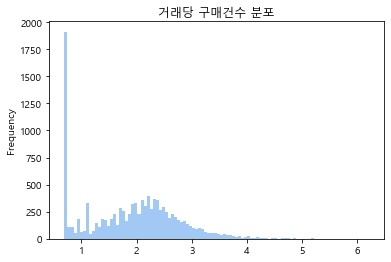

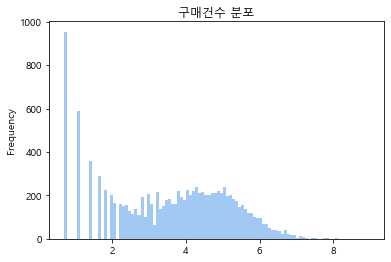

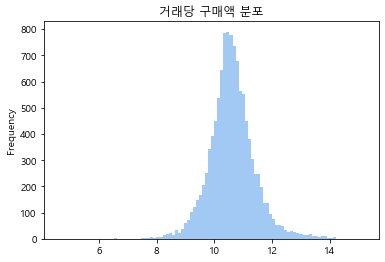

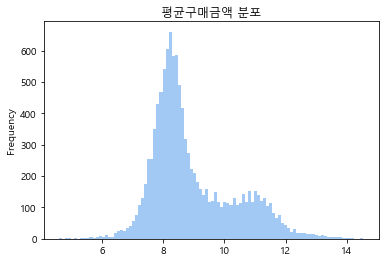

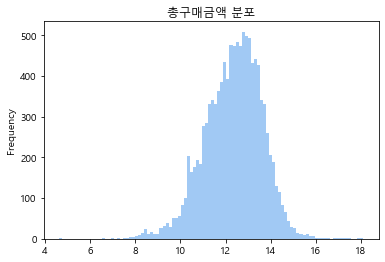

In [49]:
features.거래당구매건수.apply(lambda x: np.log1p(x)).plot.hist(bins = 100)
plt.title('거래당 구매건수 분포')
plt.show()
features.구매건수.apply(lambda x: np.log1p(x)).plot.hist(bins = 100)
plt.title('구매건수 분포')
plt.show()
features.거래당구매액.apply(lambda x: np.log1p(x)).plot.hist(bins = 100)
plt.title('거래당 구매액 분포')
plt.show()
features.평균구매금액.apply(lambda x: np.log1p(x)).plot.hist(bins = 100)
plt.title('평균구매금액 분포')
plt.show()
features.총구매금액.apply(lambda x: np.log1p(x)).plot.hist(bins = 100)
plt.title('총구매금액 분포')
plt.show()

**[2]** 최고가상품값, 최저가상품값, 상품값범위

In [50]:
df['good1_price'] = df['buy_am']//df['buy_ct']

In [51]:
f = df.groupby('clnt_id')['good1_price'].agg([
    ('최고가상품값', np.max),
    ('최저가상품값', np.min)
]).reset_index()
features = features.merge(f, how='left')

In [52]:
features['상품값범위'] = features['최고가상품값'] - features['최저가상품값']
features

,clnt_id,총구매금액,구매건수,거래당구매액,거래당구매건수,평균구매금액,최고가상품값,최저가상품값,상품값범위
0,21922,79980,14,13330,2.3,5712,13900,900,13000
1,39423,676262,202,29403,8.8,3347,32900,200,32700
2,18362,802720,161,36487,7.3,4985,17900,400,17500
3,48969,388898,178,32408,14.8,2184,13200,100,13100
4,18478,1998300,43,117547,2.5,46472,711000,990,710010
...,...,...,...,...,...,...,...,...,...
11262,58443,568000,1,568000,1.0,568000,568000,568000,0
11263,21232,362500,1,362500,1.0,362500,362500,362500,0
11264,21798,458000,1,458000,1.0,458000,458000,458000,0
11265,39693,60620,1,60620,1.0,60620,60620,60620,0


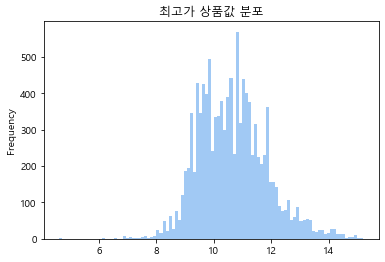

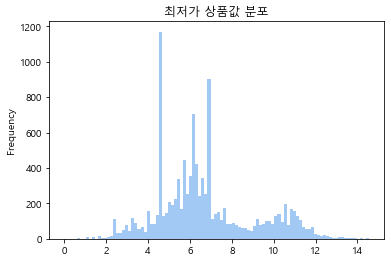

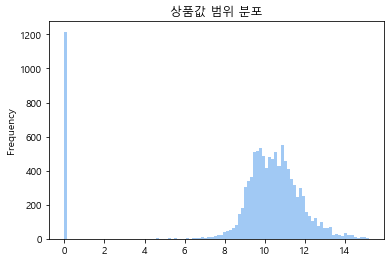

In [53]:
features.최고가상품값.apply(lambda x: np.log1p(x)).plot.hist(bins = 100)
plt.title('최고가 상품값 분포')
plt.show()
features.최저가상품값.apply(lambda x: np.log1p(x)).plot.hist(bins = 100)
plt.title('최저가 상품값 분포')
plt.show()
features.상품값범위.apply(lambda x: np.log1p(x)).plot.hist(bins =100)
plt.title('상품값 범위 분포')
plt.show()

**[3]** 구매상품종류(대/중/소)

In [54]:
f = df.groupby('clnt_id').agg({
    'clac_nm1':[('구매상품종류(대)', lambda x : x.nunique())],
    'clac_nm2':[('구매상품종류(중)', lambda x : x.nunique())],
    'clac_nm3':[('구매상품종류(소)', lambda x : x.nunique())]
}).reset_index()
f.columns = drop_column_level(f)
features = features.merge(f, how='left'); features

,clnt_id,총구매금액,구매건수,거래당구매액,거래당구매건수,평균구매금액,최고가상품값,최저가상품값,상품값범위,구매상품종류(대),구매상품종류(중),구매상품종류(소)
0,21922,79980,14,13330,2.3,5712,13900,900,13000,7,9,12
1,39423,676262,202,29403,8.8,3347,32900,200,32700,20,43,62
2,18362,802720,161,36487,7.3,4985,17900,400,17500,18,38,60
3,48969,388898,178,32408,14.8,2184,13200,100,13100,17,43,65
4,18478,1998300,43,117547,2.5,46472,711000,990,710010,13,16,21
...,...,...,...,...,...,...,...,...,...,...,...,...
11262,58443,568000,1,568000,1.0,568000,568000,568000,0,1,1,1
11263,21232,362500,1,362500,1.0,362500,362500,362500,0,1,1,1
11264,21798,458000,1,458000,1.0,458000,458000,458000,0,1,1,1
11265,39693,60620,1,60620,1.0,60620,60620,60620,0,1,1,1


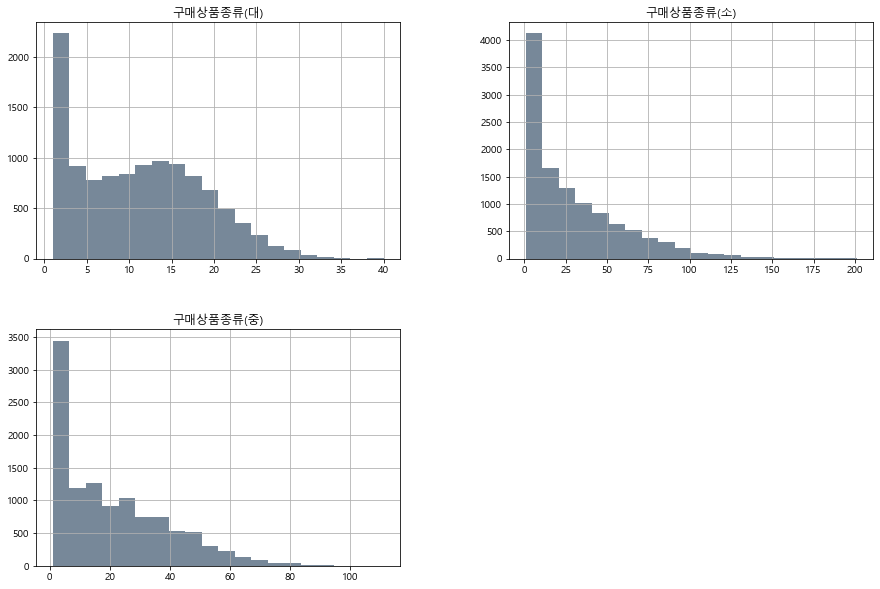

In [55]:
f.iloc[:,-3:].hist(bins=20, figsize=(15,10), color = 'lightslategrey')
plt.show()

**[4]** 주구매시간

In [56]:
f = df.groupby('clnt_id')['de_tm'].agg([
    ('주구매시간', lambda x: int(x.str[:2].value_counts().index[0]))
]).reset_index()
features = features.merge(f, how='left'); features

,clnt_id,총구매금액,구매건수,거래당구매액,거래당구매건수,평균구매금액,최고가상품값,최저가상품값,상품값범위,구매상품종류(대),구매상품종류(중),구매상품종류(소),주구매시간
0,21922,79980,14,13330,2.3,5712,13900,900,13000,7,9,12,21
1,39423,676262,202,29403,8.8,3347,32900,200,32700,20,43,62,15
2,18362,802720,161,36487,7.3,4985,17900,400,17500,18,38,60,10
3,48969,388898,178,32408,14.8,2184,13200,100,13100,17,43,65,10
4,18478,1998300,43,117547,2.5,46472,711000,990,710010,13,16,21,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11262,58443,568000,1,568000,1.0,568000,568000,568000,0,1,1,1,10
11263,21232,362500,1,362500,1.0,362500,362500,362500,0,1,1,1,1
11264,21798,458000,1,458000,1.0,458000,458000,458000,0,1,1,1,4
11265,39693,60620,1,60620,1.0,60620,60620,60620,0,1,1,1,23


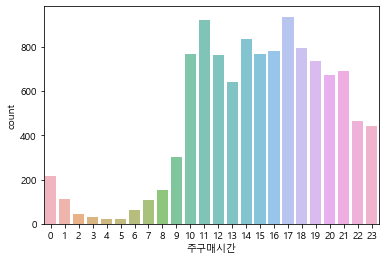

In [57]:
sns.countplot(x = '주구매시간', data = features, alpha = 0.7)
plt.show()

**[5]** 내점일수, 구매주기, 주말방문일수

In [58]:
f = df.groupby('clnt_id')['de_dt'].agg([
    ('내점일수',lambda x: x.nunique()),
    ('구매주기', lambda x: int(((x.max() - x.min()).days) / x.nunique())),
    ('주말방문일수', lambda x : (x.dt.weekday > 4).count())
]).reset_index()
features = features.merge(f, how='left'); features

,clnt_id,총구매금액,구매건수,거래당구매액,거래당구매건수,평균구매금액,최고가상품값,최저가상품값,상품값범위,구매상품종류(대),구매상품종류(중),구매상품종류(소),주구매시간,내점일수,구매주기,주말방문일수
0,21922,79980,14,13330,2.3,5712,13900,900,13000,7,9,12,21,5,16,13
1,39423,676262,202,29403,8.8,3347,32900,200,32700,20,43,62,15,19,4,134
2,18362,802720,161,36487,7.3,4985,17900,400,17500,18,38,60,10,20,4,117
3,48969,388898,178,32408,14.8,2184,13200,100,13100,17,43,65,10,10,8,100
4,18478,1998300,43,117547,2.5,46472,711000,990,710010,13,16,21,10,12,6,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11262,58443,568000,1,568000,1.0,568000,568000,568000,0,1,1,1,10,1,0,1
11263,21232,362500,1,362500,1.0,362500,362500,362500,0,1,1,1,1,1,0,1
11264,21798,458000,1,458000,1.0,458000,458000,458000,0,1,1,1,4,1,0,1
11265,39693,60620,1,60620,1.0,60620,60620,60620,0,1,1,1,23,1,0,1


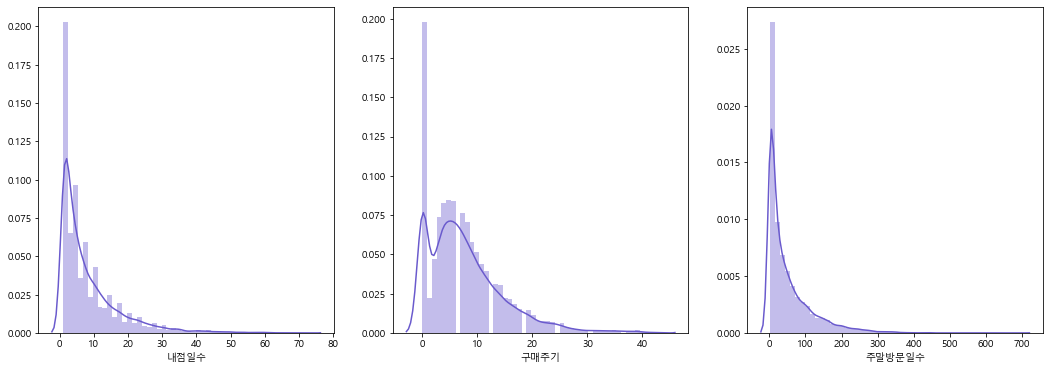

In [59]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))

sns.distplot(features.내점일수, ax=ax[0], color = 'slateblue')
sns.distplot(features.구매주기, ax=ax[1], color = 'slateblue')
sns.distplot(features.주말방문일수, ax=ax[2], color = 'slateblue')
plt.show()

**[6]** 구매추세

In [60]:
# 마지막날짜부터 91일전까지 (7일씩 13번) 매주 구매건수를 계산하여 리스트에 넣음
week_to = df.de_dt.max()
week_trans = []
for i in range(13):
    week_from = week_to + pd.DateOffset(weeks=-1)
    week_trans.append(df.query('@week_from < de_dt <= @week_to')
                      .groupby('clnt_id')['trans_id']
                      .agg([(f'w{13-i}', 'count')])
                      .reset_index())
    week_to = week_from

# 리스트로부터 데이터프레임 변환    
f = pd.DataFrame({'clnt_id': df.clnt_id.unique()})
for w in week_trans[::-1]:
    f = pd.merge(f, w, how='left')
f = f.fillna(0)
f

,clnt_id,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13
0,21922,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,6.0,0.0
1,39423,14.0,6.0,5.0,8.0,0.0,27.0,13.0,3.0,14.0,9.0,0.0,9.0,22.0
2,18362,4.0,4.0,13.0,6.0,0.0,8.0,14.0,11.0,28.0,6.0,6.0,9.0,5.0
3,48969,0.0,7.0,0.0,0.0,20.0,9.0,13.0,0.0,9.0,19.0,0.0,11.0,12.0
4,18478,4.0,3.0,0.0,8.0,0.0,0.0,2.0,8.0,1.0,0.0,1.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11262,58443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
11263,21232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
11264,21798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
11265,39693,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
f['구매추세'] = f.apply(lambda x: np.polyfit(range(13), x[1:], 1)[0].round(2), axis=1)
features = features.merge(f.iloc[:,[0,-1]], how='left'); features

,clnt_id,총구매금액,구매건수,거래당구매액,거래당구매건수,평균구매금액,최고가상품값,최저가상품값,상품값범위,구매상품종류(대),구매상품종류(중),구매상품종류(소),주구매시간,내점일수,구매주기,주말방문일수,구매추세
0,21922,79980,14,13330,2.3,5712,13900,900,13000,7,9,12,21,5,16,13,0.05
1,39423,676262,202,29403,8.8,3347,32900,200,32700,20,43,62,15,19,4,134,0.27
2,18362,802720,161,36487,7.3,4985,17900,400,17500,18,38,60,10,20,4,117,0.34
3,48969,388898,178,32408,14.8,2184,13200,100,13100,17,43,65,10,10,8,100,0.65
4,18478,1998300,43,117547,2.5,46472,711000,990,710010,13,16,21,10,12,6,32,-0.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11262,58443,568000,1,568000,1.0,568000,568000,568000,0,1,1,1,10,1,0,1,0.03
11263,21232,362500,1,362500,1.0,362500,362500,362500,0,1,1,1,1,1,0,1,0.03
11264,21798,458000,1,458000,1.0,458000,458000,458000,0,1,1,1,4,1,0,1,0.03
11265,39693,60620,1,60620,1.0,60620,60620,60620,0,1,1,1,23,1,0,1,-0.02


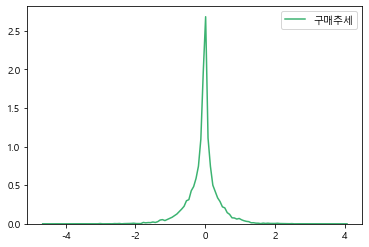

In [62]:
sns.kdeplot(features.구매추세, color = 'mediumseagreen')
plt.show()

**[7]** 가격대별 상품구매율

In [63]:
price_4q = df.groupby('pd_c')['good1_price'].mean().quantile([.25,.5,.75])
price_4q

0.25     4350.885510
0.50     8955.000000
0.75    25727.264808
Name: good1_price, dtype: float64

In [64]:
df_bh = df.query('good1_price > @price_4q.iloc[2]')
df_h = df.query('@price_4q.iloc[1] < good1_price and good1_price <= @price_4q.iloc[2]')
df_lh = df.query('@price_4q.iloc[0] < good1_price and good1_price <= @price_4q.iloc[1]')
df_l = df.query('good1_price < = @price_4q.iloc[0]')

In [65]:
f1 = (df_bh.groupby('clnt_id')['good1_price'].agg('sum')).reset_index().rename(columns = {'good1_price':'고가상품구매율'})
f2 = (df_h.groupby('clnt_id')['good1_price'].agg('sum')).reset_index().rename(columns = {'good1_price':'중저가상품구매율'})
f3 = (df_lh.groupby('clnt_id')['good1_price'].agg('sum')).reset_index().rename(columns = {'good1_price':'저가상품구매율'})
f4 = (df_l.groupby('clnt_id')['good1_price'].agg('sum')).reset_index().rename(columns = {'good1_price':'최저가상품구매율'})

In [66]:
f1 = pd.merge(f1, f2, on='clnt_id', how = 'outer')
f2 = pd.merge(f3, f4, on='clnt_id', how = 'outer')

In [67]:
f = pd.merge(f1, f2, on='clnt_id', how = 'outer')
f = f.fillna(0)
f['고가상품구매율'] = f['고가상품구매율'].astype('int')
f['중저가상품구매율'] = f['중저가상품구매율'].astype('int')
f['저가상품구매율'] = f['저가상품구매율'].astype('int')
f['최저가상품구매율'] = f['최저가상품구매율'].astype('int')

In [68]:
f['구매'] = f['고가상품구매율'] + f['중저가상품구매율'] + f['저가상품구매율'] + f['최저가상품구매율']
f['고가상품구매율'] = (f['고가상품구매율'] / f['구매']).round(2)
f['중저가상품구매율'] = (f['중저가상품구매율'] / f['구매']).round(2)
f['저가상품구매율'] = (f['저가상품구매율'] / f['구매']).round(2)
f['최저가상품구매율'] = (f['최저가상품구매율'] / f['구매']).round(2)

del f['구매']
f

,clnt_id,고가상품구매율,중저가상품구매율,저가상품구매율,최저가상품구매율
0,2,0.72,0.00,0.04,0.24
1,9,0.16,0.23,0.35,0.25
2,12,1.00,0.00,0.00,0.00
3,23,0.13,0.21,0.23,0.42
4,24,0.44,0.00,0.29,0.26
...,...,...,...,...,...
11262,68699,0.00,0.00,0.00,1.00
11263,68953,0.00,0.00,0.00,1.00
11264,69395,0.00,0.00,0.00,1.00
11265,70154,0.00,0.00,0.00,1.00


In [69]:
features = features.merge(f, how = 'left', on = 'clnt_id'); features

,clnt_id,총구매금액,구매건수,거래당구매액,거래당구매건수,평균구매금액,최고가상품값,최저가상품값,상품값범위,구매상품종류(대),...,구매상품종류(소),주구매시간,내점일수,구매주기,주말방문일수,구매추세,고가상품구매율,중저가상품구매율,저가상품구매율,최저가상품구매율
0,21922,79980,14,13330,2.3,5712,13900,900,13000,7,...,12,21,5,16,13,0.05,0.00,0.59,0.20,0.21
1,39423,676262,202,29403,8.8,3347,32900,200,32700,20,...,62,15,19,4,134,0.27,0.06,0.38,0.25,0.31
2,18362,802720,161,36487,7.3,4985,17900,400,17500,18,...,60,10,20,4,117,0.34,0.00,0.44,0.24,0.32
3,48969,388898,178,32408,14.8,2184,13200,100,13100,17,...,65,10,10,8,100,0.65,0.00,0.21,0.28,0.51
4,18478,1998300,43,117547,2.5,46472,711000,990,710010,13,...,21,10,12,6,32,-0.13,0.89,0.05,0.04,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11262,58443,568000,1,568000,1.0,568000,568000,568000,0,1,...,1,10,1,0,1,0.03,1.00,0.00,0.00,0.00
11263,21232,362500,1,362500,1.0,362500,362500,362500,0,1,...,1,1,1,0,1,0.03,1.00,0.00,0.00,0.00
11264,21798,458000,1,458000,1.0,458000,458000,458000,0,1,...,1,4,1,0,1,0.03,1.00,0.00,0.00,0.00
11265,39693,60620,1,60620,1.0,60620,60620,60620,0,1,...,1,23,1,0,1,-0.02,1.00,0.00,0.00,0.00


**[8]** 주구매경로

In [70]:
f = df.groupby('clnt_id')['biz_unit'].agg([
    ('주구매경로',lambda x : x.value_counts().index[0])
]).reset_index()
features = features.merge(f, how='left') ; features

,clnt_id,총구매금액,구매건수,거래당구매액,거래당구매건수,평균구매금액,최고가상품값,최저가상품값,상품값범위,구매상품종류(대),...,주구매시간,내점일수,구매주기,주말방문일수,구매추세,고가상품구매율,중저가상품구매율,저가상품구매율,최저가상품구매율,주구매경로
0,21922,79980,14,13330,2.3,5712,13900,900,13000,7,...,21,5,16,13,0.05,0.00,0.59,0.20,0.21,A03
1,39423,676262,202,29403,8.8,3347,32900,200,32700,20,...,15,19,4,134,0.27,0.06,0.38,0.25,0.31,A03
2,18362,802720,161,36487,7.3,4985,17900,400,17500,18,...,10,20,4,117,0.34,0.00,0.44,0.24,0.32,A03
3,48969,388898,178,32408,14.8,2184,13200,100,13100,17,...,10,10,8,100,0.65,0.00,0.21,0.28,0.51,A03
4,18478,1998300,43,117547,2.5,46472,711000,990,710010,13,...,10,12,6,32,-0.13,0.89,0.05,0.04,0.02,A03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11262,58443,568000,1,568000,1.0,568000,568000,568000,0,1,...,10,1,0,1,0.03,1.00,0.00,0.00,0.00,A01
11263,21232,362500,1,362500,1.0,362500,362500,362500,0,1,...,1,1,0,1,0.03,1.00,0.00,0.00,0.00,A01
11264,21798,458000,1,458000,1.0,458000,458000,458000,0,1,...,4,1,0,1,0.03,1.00,0.00,0.00,0.00,A01
11265,39693,60620,1,60620,1.0,60620,60620,60620,0,1,...,23,1,0,1,-0.02,1.00,0.00,0.00,0.00,A02


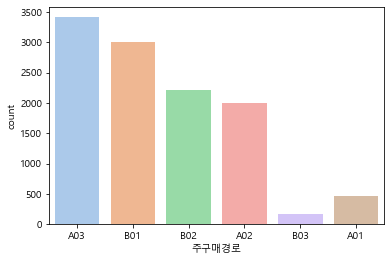

In [71]:
sns.countplot(data = features, x = '주구매경로')
plt.show()

**[9]** 성별

In [72]:
f = df.groupby('clnt_id')[['clnt_gender']].agg('max').rename(columns = {'clnt_gender':'성별'})
features = features.merge(f, how='left', on='clnt_id') ;features

,clnt_id,총구매금액,구매건수,거래당구매액,거래당구매건수,평균구매금액,최고가상품값,최저가상품값,상품값범위,구매상품종류(대),...,내점일수,구매주기,주말방문일수,구매추세,고가상품구매율,중저가상품구매율,저가상품구매율,최저가상품구매율,주구매경로,성별
0,21922,79980,14,13330,2.3,5712,13900,900,13000,7,...,5,16,13,0.05,0.00,0.59,0.20,0.21,A03,F
1,39423,676262,202,29403,8.8,3347,32900,200,32700,20,...,19,4,134,0.27,0.06,0.38,0.25,0.31,A03,F
2,18362,802720,161,36487,7.3,4985,17900,400,17500,18,...,20,4,117,0.34,0.00,0.44,0.24,0.32,A03,F
3,48969,388898,178,32408,14.8,2184,13200,100,13100,17,...,10,8,100,0.65,0.00,0.21,0.28,0.51,A03,F
4,18478,1998300,43,117547,2.5,46472,711000,990,710010,13,...,12,6,32,-0.13,0.89,0.05,0.04,0.02,A03,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11262,58443,568000,1,568000,1.0,568000,568000,568000,0,1,...,1,0,1,0.03,1.00,0.00,0.00,0.00,A01,F
11263,21232,362500,1,362500,1.0,362500,362500,362500,0,1,...,1,0,1,0.03,1.00,0.00,0.00,0.00,A01,F
11264,21798,458000,1,458000,1.0,458000,458000,458000,0,1,...,1,0,1,0.03,1.00,0.00,0.00,0.00,A01,M
11265,39693,60620,1,60620,1.0,60620,60620,60620,0,1,...,1,0,1,-0.02,1.00,0.00,0.00,0.00,A02,F


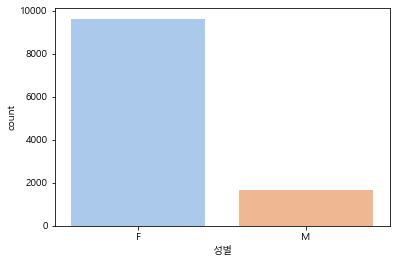

In [73]:
sns.countplot(data = features, x = '성별')
plt.show()

**다 만든 features 정보 확인**

In [74]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11267 entries, 0 to 11266
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   clnt_id    11267 non-null  int64  
 1   총구매금액      11267 non-null  int32  
 2   구매건수       11267 non-null  int64  
 3   거래당구매액     11267 non-null  int32  
 4   거래당구매건수    11267 non-null  float64
 5   평균구매금액     11267 non-null  int64  
 6   최고가상품값     11267 non-null  int64  
 7   최저가상품값     11267 non-null  int64  
 8   상품값범위      11267 non-null  int64  
 9   구매상품종류(대)  11267 non-null  int64  
 10  구매상품종류(중)  11267 non-null  int64  
 11  구매상품종류(소)  11267 non-null  int64  
 12  주구매시간      11267 non-null  int64  
 13  내점일수       11267 non-null  int64  
 14  구매주기       11267 non-null  int64  
 15  주말방문일수     11267 non-null  int64  
 16  구매추세       11267 non-null  float64
 17  고가상품구매율    11267 non-null  float64
 18  중저가상품구매율   11267 non-null  float64
 19  저가상품구매율    11267 non-null  float64
 20  최저가상품구

## 군집 나누기

In [75]:
group = pd.DataFrame({'clnt_id': features.clnt_id.unique()});len(group)

11267

### 1. 구매금액(P)

* 가격대별 구매율과 상품값 범위로 구매금액 측면에서의 점수부여

#### 가격대별 구매율 점수

In [76]:
# 고가상품구매율 > 0.5   :   4

# 중저가상품구매율 > 0.5   :   3
# 고가상품구매율 + 중저가상품구매율 > 0.5   :   3

# 저가상품구매율 > 0.5   :   2
# 저가상품구매율 + 중저가상품구매율 > 0.5   :   2

# 최저가상품구매율 > 0.5   :   1
# 저가상품구매율 + 최저가상품구매율 > 0.5   :   1

In [77]:
p4 = features.query('고가상품구매율 >= 0.5')
pp = features.query('고가상품구매율 < 0.5')

p3 = pp.query('중저가상품구매율 >= 0.5')
pp = pp.query('중저가상품구매율 < 0.5')
                      
p2 = pp.query('저가상품구매율 >= 0.5')
pp = pp.query('저가상품구매율 < 0.5')
                      
p1 = pp.query('최저가상품구매율 >= 0.5')
pp = pp.query('최저가상품구매율 < 0.5')

In [78]:
p3_1 = pp.query('고가상품구매율+중저가상품구매율 >= 0.5')
pp = pp.query('고가상품구매율+중저가상품구매율 < 0.5')

p2_1 = pp.query('저가상품구매율+중저가상품구매율 >= 0.5')
pp = pp.query('저가상품구매율+중저가상품구매율 < 0.5')

p1_1 = pp.query('저가상품구매율+최저가상품구매율 >= 0.5')
pp = pp.query('저가상품구매율+최저가상품구매율 < 0.5')

In [79]:
len(pp)

0

In [80]:
p4['구매율점수'] = 4

p3 = pd.concat([p3, p3_1])
p3['구매율점수'] = 3

p2 = pd.concat([p2, p2_1])
p2['구매율점수'] = 2

p1 = pd.concat([p1, p1_1])
p1['구매율점수'] = 1

pp = pd.concat([p1, p2, p3, p4])

C:\Users\Yoon Kyung Seo\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### 상품값 범위 점수 ( 4분위수를 기준으로 나눔 - 4분위수는 features 7번참고) 

In [81]:
# 25727 이상 : 4점
# 8955 ~ 25727 : 3점
# 4351 ~ 8955 : 2점
# 4351 이하

In [82]:
p4 = pp.query('상품값범위 >= 25727')
pp = pp.query('상품값범위 < 25727')
p4['상품값범위점수'] = 4

p3 = pp.query('상품값범위 >= 8955')
pp = pp.query('상품값범위 < 8955')
p3['상품값범위점수'] = 3

p2 = pp.query('상품값범위 >= 4351')
p1 = pp.query('상품값범위 < 4351')
p2['상품값범위점수'] = 2
p1['상품값범위점수'] = 1

pp = pd.concat([p1, p2, p3, p4])

C:\Users\Yoon Kyung Seo\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Yoon Kyung Seo\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


####  - 가격대별 구매율 점수와 상품값 범위 점수에 따른 최종 P 점수

In [83]:
# 가격대별 구매율 = 4   :   4
# 가격대별 구매율 = 3, 상품값 범위 = 1/2   :   4

# 가격대별 구매율 = 3, 상품값 범위 = 3/4   :   3
# 가격대별 구매율 = 2, 상품값 범위 = 3/4   :   3

# 가격대별 구매율 = 2, 상품값 범위 = 1/2   :   2
# 가격대별 구매율 = 1, 상품값 범위 = 3/4   :   2

# 가격대별 구매율 = 1, 상품값 범위 = 1/2   :   1

In [84]:
p_score = pp[['clnt_id','구매율점수','상품값범위점수']]
group = group.merge(p_score, how='left')

In [85]:
p4 = group.query('구매율점수 == 4')
p4_1 = group.query('구매율점수 == 3').query('상품값범위점수 == 1 or 상품값범위점수 == 2')
p4 = pd.concat([p4, p4_1])
p4['p_score'] = 4

p3 = group.query('구매율점수 == 3').query('상품값범위점수 == 3 or 상품값범위점수 == 4')
p3_1 = group.query('구매율점수 == 2').query('상품값범위점수 == 3 or 상품값범위점수 == 4')
p3 = pd.concat([p3, p3_1])
p3['p_score'] = 3

p2 = group.query('구매율점수 == 2').query('상품값범위점수 == 1 or 상품값범위점수 == 2')
p2_1 = group.query('구매율점수 == 1').query('상품값범위점수 == 3 or 상품값범위점수 == 4')
p2 = pd.concat([p2, p2_1])
p2['p_score'] = 2

p1 = group.query('구매율점수 == 1').query('상품값범위점수 == 1 or 상품값범위점수 == 2')
p1['p_score'] = 1

group = pd.concat([p1, p2, p3, p4])

In [86]:
del pp['구매율점수'], pp['상품값범위점수'], group['구매율점수'], group['상품값범위점수']

In [87]:
group

,clnt_id,p_score
141,37952,1
363,36509,1
391,22844,1
606,62783,1
632,32656,1
...,...,...
11210,19621,4
11233,4166,4
11240,2313,4
11247,56679,4


### 2. 구매일(D)

* 구매주기와 구매추세 측면에서의 점수부여

#### 구매주기 점수

In [88]:
features.구매주기.min(), features.구매주기.max()

(0, 43)

In [89]:
# 구매주기 1~10 : 4점
# 구매주기 11~20 : 3점
# 구매주기 21~30: 2점
# 구매주기 31~43 or 0 : 1점

In [90]:
d4 = pp.query('1 <= 구매주기 <= 10')
d4['구매주기점수'] = 4

d3 = pp.query('11 <= 구매주기 <= 20')
d3['구매주기점수'] = 3

d2 = pp.query('21 <= 구매주기 <= 30')
d2['구매주기점수'] = 2

d1 = pp.query('31 <= 구매주기 <= 43 or 구매주기 == 0')
d1['구매주기점수'] = 1

dd = pd.concat([d1, d2, d3, d4])

C:\Users\Yoon Kyung Seo\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Yoon Kyung Seo\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Yoon Kyung Seo\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

#### 구매추세 점수

In [91]:
features.구매추세.min(), features.구매추세.max()

(-4.55, 3.96)

In [92]:
# 구매추세 2.00 ~ 3.96 : 4점
# 구매추세 0.00 ~ 2.00 : 3점
# 구매추세 -2.25 ~ 0.00 : 2점
# 구매추세 -4.55 ~ -2.25 : 1점

In [93]:
d4 = dd.query('2 <= 구매추세 < 4')
d4['구매추세점수'] = 4

d3 = dd.query('0 <= 구매추세 < 2')
d3['구매추세점수'] = 3

d2 = dd.query('-2.25 <= 구매추세 < 0')
d2['구매추세점수'] = 2

d1 = dd.query('-4.55 <= 구매추세 < -2.25')
d1['구매추세점수'] = 1

dd = pd.concat([d1, d2, d3, d4])

C:\Users\Yoon Kyung Seo\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Yoon Kyung Seo\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Yoon Kyung Seo\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [94]:
d_score = dd[['clnt_id','구매주기점수','구매추세점수']]
group = group.merge(d_score, how='left')

####  - 구매주기 점수와 구매추세 점수에 따른 최종 D 점수

In [95]:
# 구매주기 = 4, 구매추세 = 4/3   :   4
# 구매주기 = 3, 구매추세 = 4   :   4

# 구매주기 = 4, 구매추세 = 2   :    3
# 구매주기 = 3, 구매추세 = 2/3   :   3
# 구매주기 = 2, 구매추세 = 4   :   3

# 구매주기 = 4, 구매추세 = 1   :   2
# 구매주기 = 3, 구매추세 = 1   :   2
# 구매주기 = 2, 구매추세 = 2/3   :   2
# 구매주기 = 1, 구매추세 = 4   :   2

# 구매주기 = 2, 구매추세 = 1   :   1
# 구매주기 = 1, 구매추세 = 1,2,3   :   1

In [96]:
d4 = group.query('구매주기점수 == 4').query('구매추세점수 == 3 or 구매추세점수 == 4')
d4_1 = group.query('구매주기점수 == 3 and 구매추세점수 == 4')
d4 = pd.concat([d4, d4_1])
d4['d_score'] = 4

d3 = group.query('구매주기점수 == 4 and 구매추세점수 == 2')
d3_1 = group.query('구매주기점수 == 3').query('구매추세점수 == 2 or 구매추세점수 == 3')
d3_2 = group.query('구매주기점수 == 2 and 구매추세점수 == 4')
d3 = pd.concat([d3, d3_1, d3_2])
d3['d_score'] = 3

d2 = group.query('구매주기점수 == 4 and 구매추세점수 == 1')
d2_1 = group.query('구매주기점수 == 3 and 구매추세점수 == 1')
d2_2 = group.query('구매주기점수 == 2').query('구매추세점수 == 2 or 구매추세점수 == 3')
d2_3 = group.query('구매주기점수 == 1 and 구매추세점수 == 4')
d2 = pd.concat([d2, d2_1, d2_2, d2_3])
d2['d_score'] = 2

d1 = group.query('구매주기점수 == 2 and 구매추세점수 == 1')
d1_1 = group.query('구매주기점수 == 1').query('구매추세점수 == 1 or 구매추세점수 == 2 or 구매추세점수 == 3')
d1 = pd.concat([d1, d1_1])
d1['d_score'] = 1

group = pd.concat([d1, d2, d3, d4])

In [97]:
del dd['구매주기점수'], dd['구매추세점수'], group['구매주기점수'], group['구매추세점수']

In [98]:
group

,clnt_id,p_score,d_score
7,9459,1,1
11,13716,1,1
18,20532,1,1
19,34070,1,1
24,36536,1,1
...,...,...,...
11044,9734,4,4
11081,71138,4,4
11113,23701,4,4
11213,71459,4,4


### 3. 구매건수(C)

* 거래당 구매건수와 구매건수 측면에서의 점수부여

#### 거래당 구매건수 점수

In [99]:
dd.groupby('clnt_id')['거래당구매건수'].mean().quantile([.25,.5,.75])

0.25     2.1
0.50     6.4
0.75    11.0
Name: 거래당구매건수, dtype: float64

In [100]:
# 거래당구매건수 11 ~   :   4
# 거래당구매건수 6.4 ~ 11   :   3
# 거래당구매건수 2.1 ~ 6.4   :   2
# 거래당구매건수 ~ 2.1   :   1

In [101]:
c4 = dd.query('거래당구매건수 > 11')
c4['거래당구매건수점수'] = 4

c3 = dd.query('6.4 < 거래당구매건수 <= 11')
c3['거래당구매건수점수'] = 3

c2 = dd.query('2.1 < 거래당구매건수 <= 6.4')
c2['거래당구매건수점수'] = 2

c1 = dd.query('거래당구매건수 <= 2.1')
c1['거래당구매건수점수'] = 1

dd = pd.concat([c1, c2, c3, c4])

C:\Users\Yoon Kyung Seo\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Yoon Kyung Seo\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Yoon Kyung Seo\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

#### 구매건수 점수

In [102]:
dd.groupby('clnt_id')['구매건수'].mean().quantile([.25,.5,.75]).astype('int')

0.25      8
0.50     41
0.75    127
Name: 구매건수, dtype: int32

In [103]:
# 구매건수 127 ~   :   4   
# 구매건수 41 ~ 127   :   3
# 구매건수 8 ~ 41   :   2
# 구매건수 ~ 8   :   1

In [104]:
c4 = dd.query('구매건수 > 127')
c4['구매건수점수'] = 4

c3 = dd.query('41 < 구매건수 <= 127')
c3['구매건수점수'] = 3

c2 = dd.query('8 < 구매건수 <= 41')
c2['구매건수점수'] = 2

c1 = dd.query('구매건수 <= 8')
c1['구매건수점수'] = 1

cc = pd.concat([c1, c2, c3, c4])

C:\Users\Yoon Kyung Seo\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Yoon Kyung Seo\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Yoon Kyung Seo\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [105]:
c_score = cc[['clnt_id','거래당구매건수점수','구매건수점수']]
group = group.merge(c_score, how='left')

####  - 거래당 구매건수 점수와 구매건수 점수에 따른 최종 C 점수

In [106]:
# 구매건수 = 4, 거래당구매건수 = 1/2   :   4
# 구매건수 = 3, 거래당구매건수 = 1   :   4

# 구매건수 = 4, 거래당구매건수 = 3/4   :   3
# 구매건수 = 3, 거래당구매건수 = 2/3   :   3

# 구매건수 = 3, 거래당구매건수 = 4   :   2
# 구매건수 = 2, 거래당구매건수 = 1/2/3   :   2

# 구매건수 = 2, 거래당구매건수 = 4   :   1
# 구매건수 = 1   :   1

In [107]:
c4 = group.query('구매건수점수 == 4').query('거래당구매건수점수 == 1 or 거래당구매건수점수 == 2')
c4_1 = group.query('구매건수점수 == 3 and 거래당구매건수점수 == 1')
c4 = pd.concat([c4, c4_1])
c4['c_score'] = 4

c3 = group.query('구매건수점수 == 4').query('거래당구매건수점수 == 3 or 거래당구매건수점수 == 4')
c3_1 = group.query('구매건수점수 == 3').query('거래당구매건수점수 == 2 or 거래당구매건수점수 == 3')
c3 = pd.concat([c3, c3_1])
c3['c_score'] = 3

c2 = group.query('구매건수점수 == 3 and 거래당구매건수점수 == 4')
c2_1 = group.query('구매건수점수 == 2').query('거래당구매건수점수 == 1 or 거래당구매건수점수 == 2 or 거래당구매건수점수 == 3')
c2 = pd.concat([c2, c2_1])
c2['c_score'] = 2

c1 = group.query('구매건수점수 == 2 and 거래당구매건수점수 == 4')
c1_1 = group.query('구매건수점수 == 1')
c1 = pd.concat([c1, c1_1])
c1['c_score'] = 1

group = pd.concat([c1, c2, c3, c4])

In [108]:
del cc, group['구매건수점수'], group['거래당구매건수점수']

In [109]:
group

,clnt_id,p_score,d_score,c_score
1,13716,1,1,1
2,20532,1,1,1
5,11502,1,1,1
6,12533,1,1,1
8,24591,1,1,1
...,...,...,...,...
10650,33252,4,4,4
10743,66389,4,4,4
10807,42301,4,4,4
10886,24234,4,4,4


In [110]:
group['PDC'] = group['p_score'].map(str) + group['d_score'].map(str) + group['c_score'].map(str)

In [111]:
group.PDC.nunique()

57

In [112]:
# P = 가격대별 구매율, 상품값범위
# D = 구매주기, 구매추세
# C = 구매건수, 거래당구매건수

In [113]:
weights = [4, 4, 2]
group['PDCscore'] = weights[0] * group['p_score'] + weights[1] * group['d_score'] + weights[2] * group['c_score']
group

,clnt_id,p_score,d_score,c_score,PDC,PDCscore
1,13716,1,1,1,111,10
2,20532,1,1,1,111,10
5,11502,1,1,1,111,10
6,12533,1,1,1,111,10
8,24591,1,1,1,111,10
...,...,...,...,...,...,...
10650,33252,4,4,4,444,40
10743,66389,4,4,4,444,40
10807,42301,4,4,4,444,40
10886,24234,4,4,4,444,40


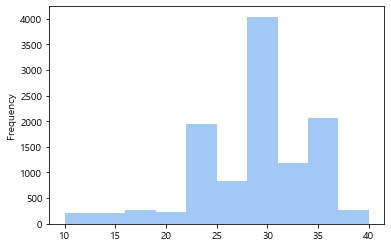

In [114]:
group.PDCscore.plot.hist()

# PD기준 최종 Customer Segment

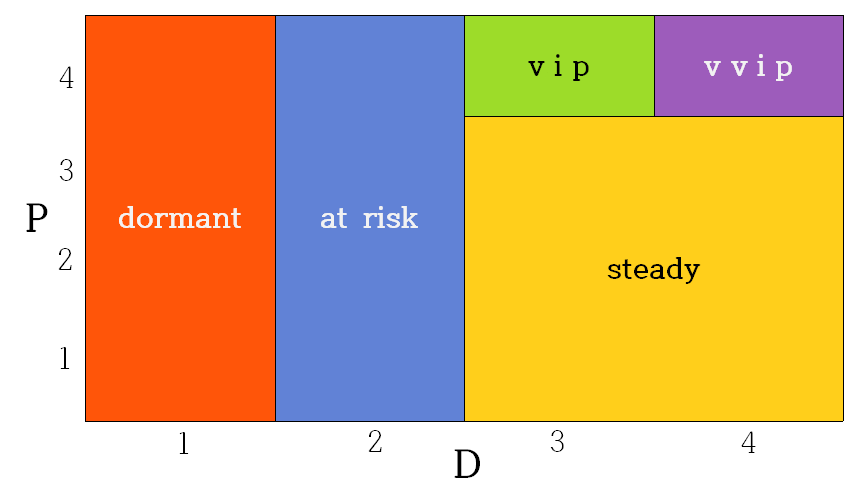

In [115]:
seg_map = {
    r'1[1-4]': 'dormant',
    r'2[1-4]': 'at risk',
    r'34': 'vip',
    r'44': 'vvip',
    r'[3-4][1-3]': 'steady'
}

group['segment'] = group['d_score'].map(str) + group['p_score'].map(str)
group['segment'] = group['segment'].replace(seg_map, regex = True)

In [116]:
pdc = group[['clnt_id', 'segment']]
df = pd.merge(df, pdc)

* PD grid에 C정보 추가

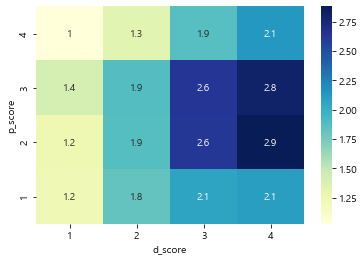

In [117]:
pdc = pd.pivot_table(group, index = 'p_score', columns = 'd_score', values = 'c_score', aggfunc = np.mean).iloc[::-1,:]
sns.heatmap(pdc, annot = True, cmap = 'YlGnBu')

### segment별 비교

* 각 segment별 고객의 수

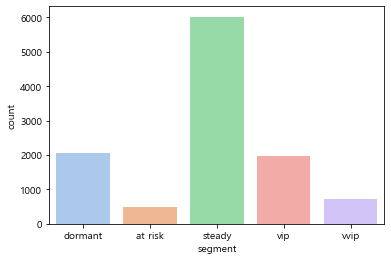

In [118]:
sns.countplot(data = group, x = 'segment')
plt.show()

In [119]:
len(df.query('segment == "steady"'))+len(df.query('segment == "dormant"'))+len(df.query('segment == "at risk"'))+len(df.query('segment == "vvip"'))+len(df.query('segment == "vip"'))
df.clnt_id.nunique()

11267

* segment별 구매시간

In [120]:
df['de_tm'] = df['de_tm'].agg(lambda x : x[:2]).astype('int')

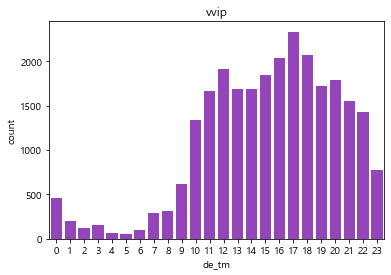

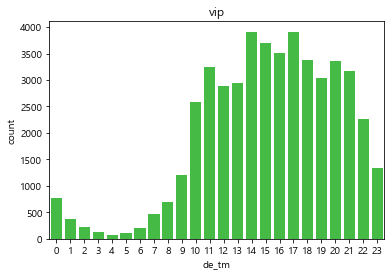

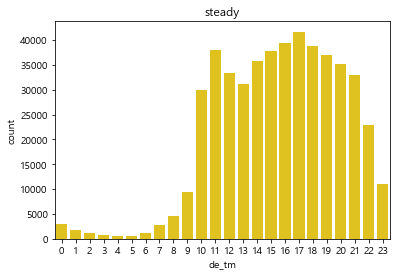

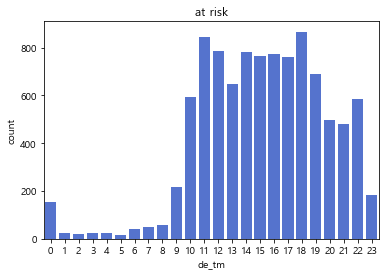

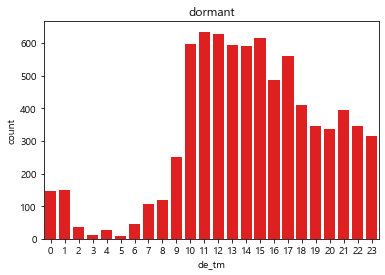

In [121]:
sns.countplot(data = df.query('segment == "vvip"'), x = 'de_tm', color = 'darkorchid')
plt.title('vvip')
plt.show()

sns.countplot(data = df.query('segment == "vip"'), x = 'de_tm', color = 'limegreen')
plt.title('vip')
plt.show()

sns.countplot(data = df.query('segment == "steady"'), x = 'de_tm', color = 'gold')
plt.title('steady')
plt.show()

sns.countplot(data = df.query('segment == "at risk"'), x = 'de_tm', color = 'royalblue')
plt.title('at risk')
plt.show()

sns.countplot(data = df.query('segment == "dormant"'), x = 'de_tm', color = 'red')
plt.title('dormant')
plt.show()

* segment별 구매상품종류(대)

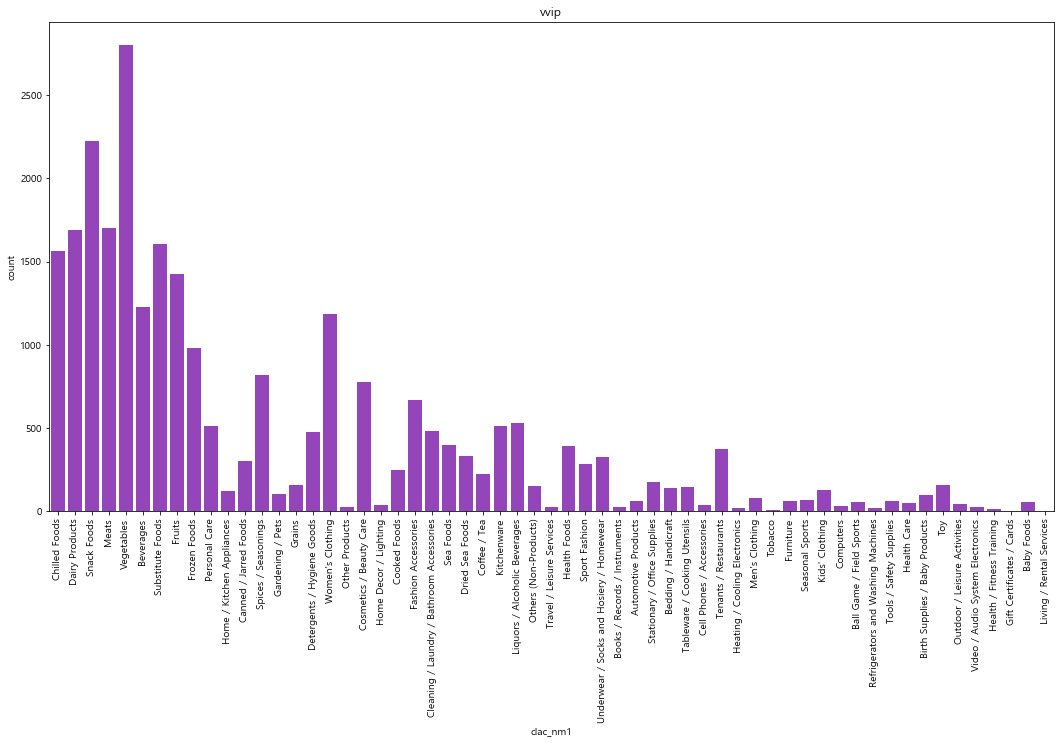

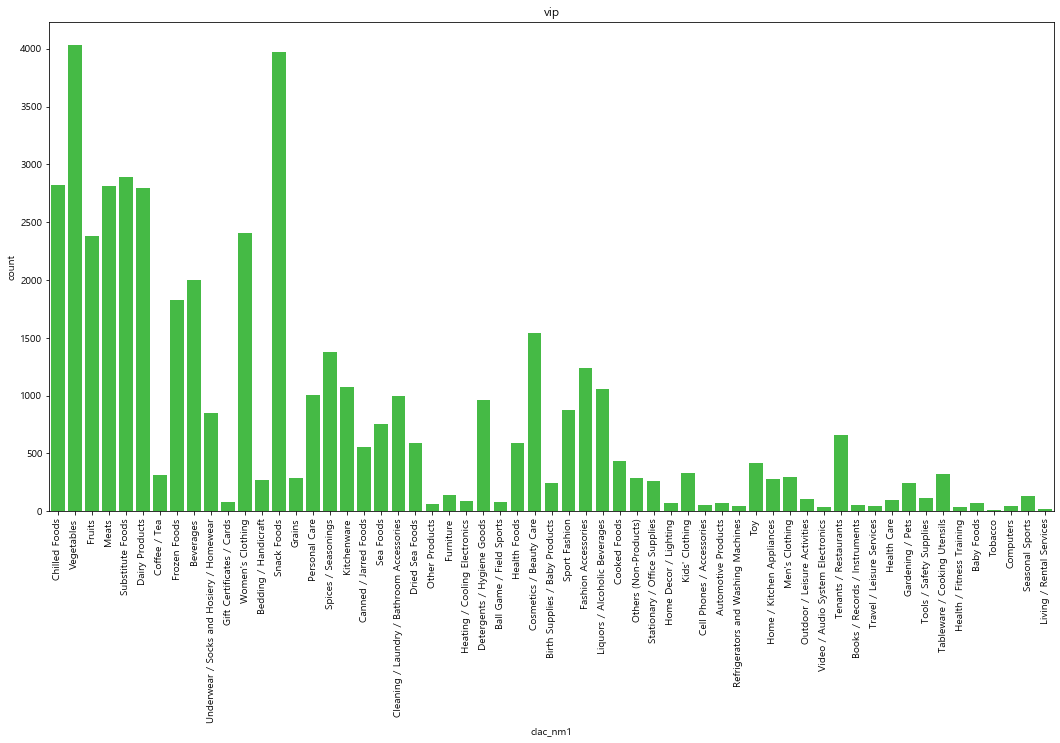

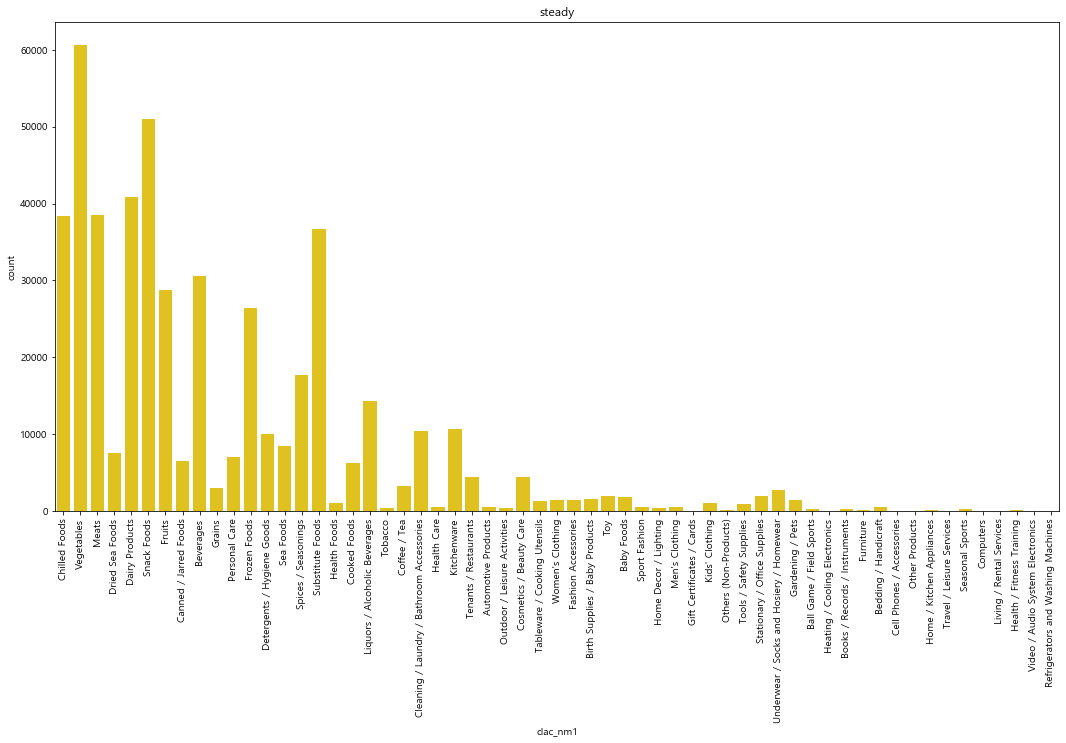

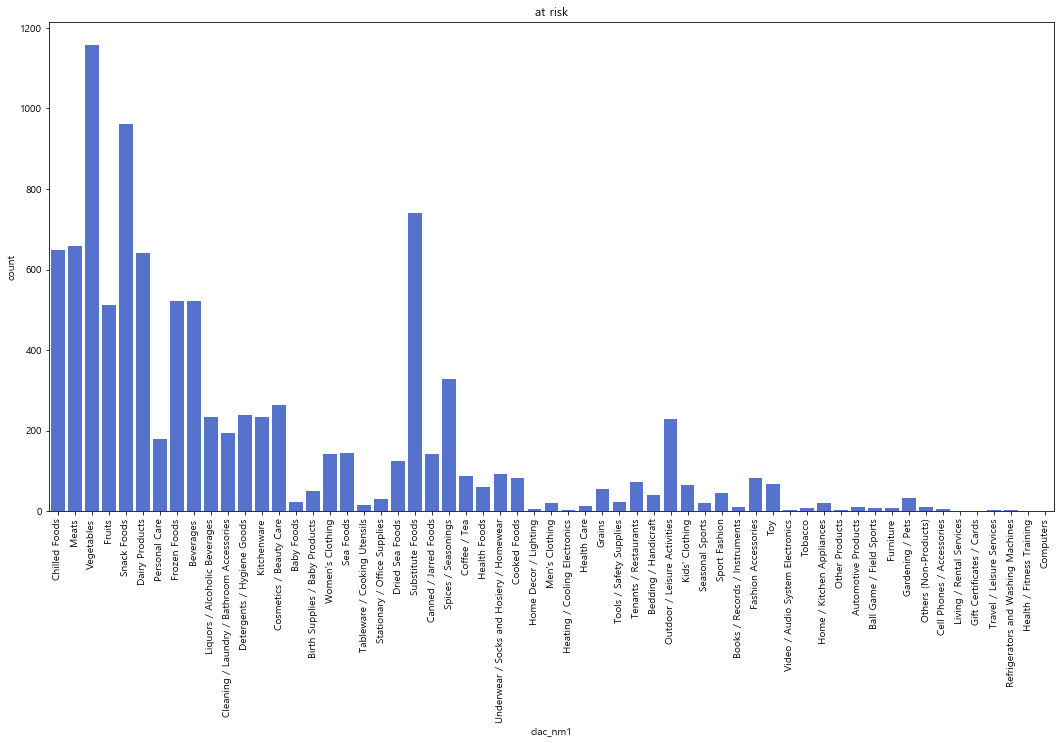

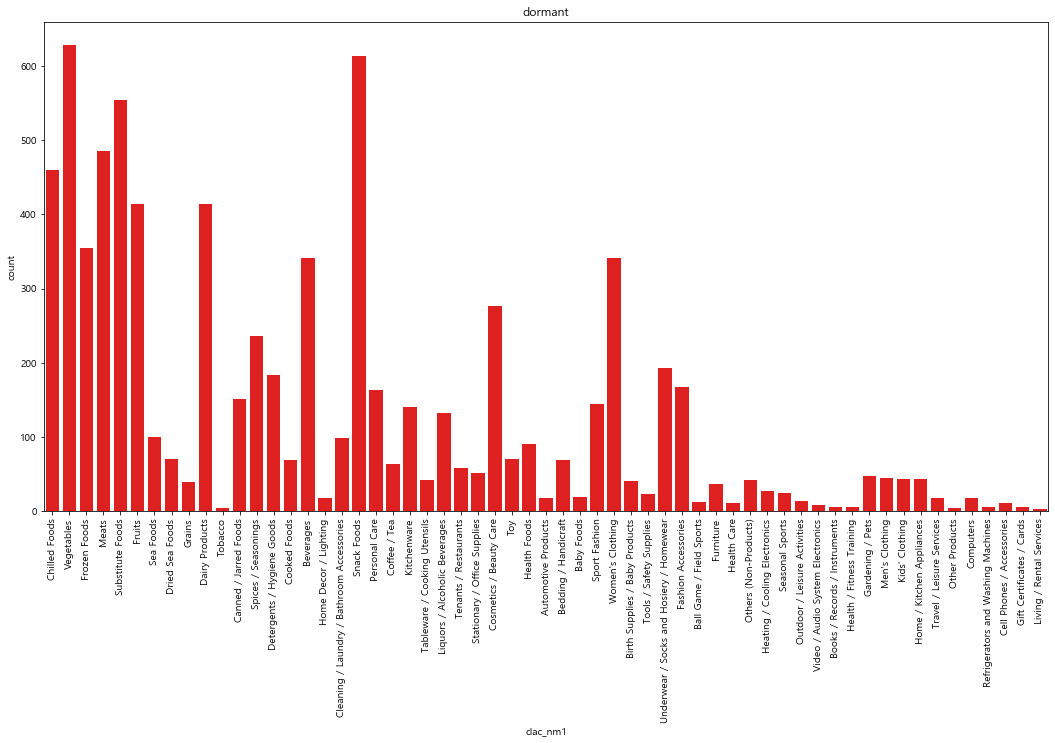

In [122]:
plt.figure(figsize = (18,9))
sns.countplot(data = df.query('segment == "vvip"'), x = 'clac_nm1', color = 'darkorchid')
plt.title('vvip')
plt.xticks(rotation = 90)
plt.show()

plt.figure(figsize = (18,9))
sns.countplot(data = df.query('segment == "vip"'), x = 'clac_nm1', color = 'limegreen')
plt.title('vip')
plt.xticks(rotation = 90)
plt.show()

plt.figure(figsize = (18,9))
sns.countplot(data = df.query('segment == "steady"'), x = 'clac_nm1', color = 'gold')
plt.title('steady')
plt.xticks(rotation = 90)
plt.show()

plt.figure(figsize = (18,9))
sns.countplot(data = df.query('segment == "at risk"'), x = 'clac_nm1', color = 'royalblue')
plt.title('at risk')
plt.xticks(rotation = 90)
plt.show()

plt.figure(figsize = (18,9))
sns.countplot(data = df.query('segment == "dormant"'), x = 'clac_nm1', color = 'red')
plt.title('dormant')
plt.xticks(rotation = 90)
plt.show()

* segment별 업종단위(A = 온라인, B = 오프라인)

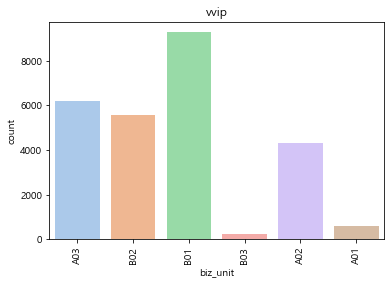

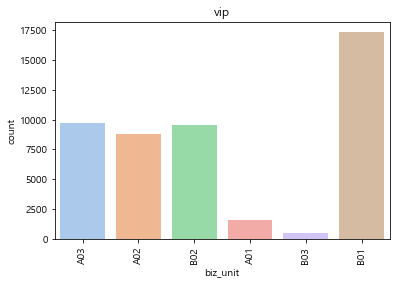

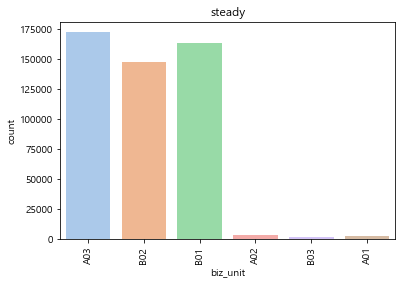

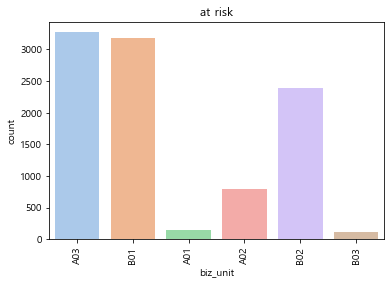

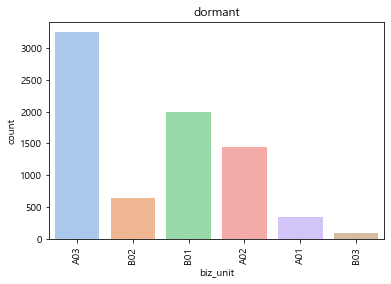

In [123]:
sns.countplot(data = df.query('segment == "vvip"'), x = 'biz_unit')
plt.title('vvip')
plt.xticks(rotation = 90)
plt.show()

sns.countplot(data = df.query('segment == "vip"'), x = 'biz_unit')
plt.title('vip')
plt.xticks(rotation = 90)
plt.show()

sns.countplot(data = df.query('segment == "steady"'), x = 'biz_unit')
plt.title('steady')
plt.xticks(rotation = 90)
plt.show()

sns.countplot(data = df.query('segment == "at risk"'), x = 'biz_unit')
plt.title('at risk')
plt.xticks(rotation = 90)
plt.show()

sns.countplot(data = df.query('segment == "dormant"'), x = 'biz_unit')
plt.title('dormant')
plt.xticks(rotation = 90)
plt.show()

* segment별 주말방문일수

In [124]:
pdc = group[['clnt_id', 'segment']]
features = pd.merge(features, pdc)

In [125]:
a = features.groupby('segment')[['주말방문일수']].agg('count').reset_index()

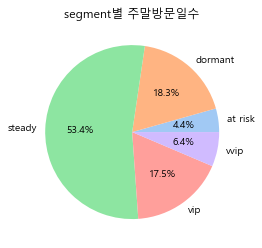

In [126]:
labels = a['segment']
sizes = a['주말방문일수']
plt.pie(sizes, labels = labels, autopct = '%1.1f%%')
plt.title('segment별 주말방문일수')
plt.show()

* segment별 성별 비

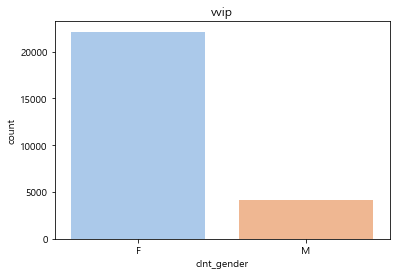

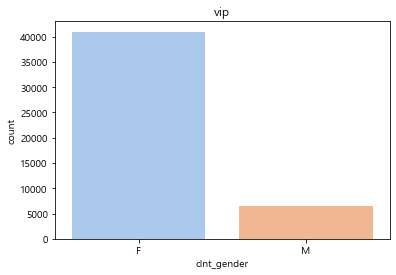

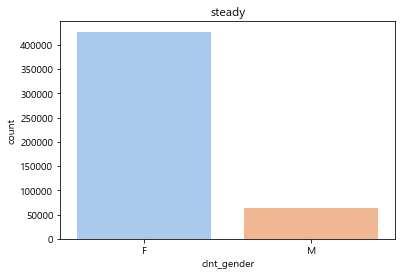

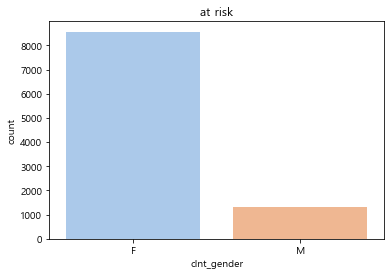

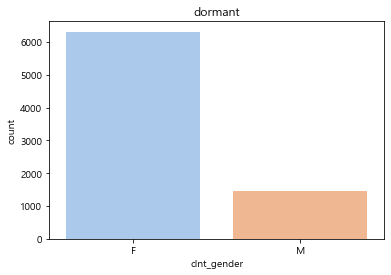

In [127]:
sns.countplot(data = df.query('segment == "vvip"'), x = 'clnt_gender')
plt.title('vvip')
plt.show()

sns.countplot(data = df.query('segment == "vip"'), x = 'clnt_gender')
plt.title('vip')
plt.show()

sns.countplot(data = df.query('segment == "steady"'), x = 'clnt_gender')
plt.title('steady')
plt.show()

sns.countplot(data = df.query('segment == "at risk"'), x = 'clnt_gender')
plt.title('at risk')
plt.show()

sns.countplot(data = df.query('segment == "dormant"'), x = 'clnt_gender')
plt.title('dormant')
plt.show()

### clac_nm3 항목 정리

In [128]:
store_data = pd.pivot_table(df, index='clnt_id', columns='clac_nm3', values='buy_ct', aggfunc=np.size, fill_value=0) \
            .applymap(lambda x: 1 if x>=1 else 0).reset_index()
transactions = store_data.iloc[:,1:]  # 고객ID 제외
transactions

clac_nm3,,Accessory Bags,Accident Prevention Equipment,Adhesive Tapes,Adhesives,Adult's Bed Covers and Skirts,Adult's Diapers,Adult's Disposable Briefes,Adults' Bed Fillings,Adults' Bedding Sets,...,Yoga / Pilates Clothing,Yoga Mats / Exercise Mats,Yoghurts / Chunggukjang Makers,Yogurt Drinks,Young Pumpkins,Young Radishes,Yuzus / Quinces,Zipper Poly Bags / Plastic Bags,kelp,life Vests / Safety Accessories
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11262,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11263,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11264,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11265,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [129]:
# 가장 많이 구매한 상품 5개
transactions.sum().sort_values(ascending=False).head()

clac_nm3
Chicken Eggs      4542
Ramens            4399
General Snacks    4167
Fresh Milk        4066
Tofu              3971
dtype: int64

#### 빈발항목추출

In [130]:
from mlxtend.frequent_patterns import apriori, association_rules

In [131]:
freq_items = apriori(transactions, min_support=0.1, use_colnames=True)
freq_items.sort_values(by='support', ascending=False)

,support,itemsets
8,0.403124,(Chicken Eggs)
62,0.390432,(Ramens)
41,0.369841,(General Snacks)
33,0.360877,(Fresh Milk)
73,0.352445,(Tofu)
...,...,...
463,0.100204,"(Corn Snacks, General Snacks, Fish Cakes)"
474,0.100115,"(Spoon Type Yogurts, Ramens, Corn Snacks)"
180,0.100115,"(Cookies, Water)"
373,0.100027,"(Cheese, General Snacks, Fresh Milk)"


In [132]:
freq_items['length'] = freq_items['itemsets'].apply(lambda x: len(x))
freq_items.query('length >= 2')

,support,itemsets,length
80,0.117334,"(Bananas, Bibim Ramens)",2
81,0.101269,"(Bananas, Cheese)",2
82,0.178930,"(Bananas, Chicken Eggs)",2
83,0.111298,"(Cookies, Bananas)",2
84,0.117689,"(Bananas, Corn Snacks)",2
...,...,...,...
562,0.107038,"(Corn Snacks, Ramens, General Snacks, Fresh Milk)",4
563,0.101979,"(Corn Snacks, Tofu, General Snacks, Fresh Milk)",4
564,0.105618,"(Tofu, Corn Snacks, Ramens, General Snacks)",4
565,0.118399,"(Tofu, Ramens, General Snacks, Fresh Milk)",4


* 연관규칙 도출

In [133]:
rules = association_rules(freq_items, metric='confidence')
rules.query('confidence >= 0.8')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(Bananas, Tofu)",(Chicken Eggs),0.164729,0.403124,0.131978,0.801185,1.987441,0.065572,3.002172
1,"(Bananas, Corn Snacks)",(General Snacks),0.117689,0.369841,0.100648,0.855204,2.312354,0.057122,4.352035
2,"(Tofu, Bibim Ramens)",(Chicken Eggs),0.169965,0.403124,0.139611,0.821410,2.037610,0.071094,3.342156
3,"(Cookies, Bibim Ramens)",(General Snacks),0.127186,0.369841,0.104642,0.822749,2.224602,0.057603,3.555188
4,"(Cookies, Bibim Ramens)",(Ramens),0.127186,0.390432,0.103311,0.812282,2.080468,0.053653,3.247251
...,...,...,...,...,...,...,...,...,...
107,"(Ramens, Spoon Type Yogurts, Tofu)",(Chicken Eggs),0.125499,0.403124,0.106949,0.852192,2.113970,0.056358,4.038193
108,"(Corn Snacks, Ramens, Fresh Milk)",(General Snacks),0.122393,0.369841,0.107038,0.874547,2.364655,0.061772,5.023058
109,"(Corn Snacks, Tofu, Fresh Milk)",(General Snacks),0.116890,0.369841,0.101979,0.872437,2.358952,0.058748,4.939995
110,"(Ramens, Corn Snacks, Tofu)",(General Snacks),0.121239,0.369841,0.105618,0.871157,2.355489,0.060779,4.890892


In [134]:
# 빈발항목에 들어간 구매상품종류(소)
lev3_freq_items = np.unique([item for items in freq_items.itemsets for item in items])
lev3_freq_items

array(['Apples', 'Bacons', 'Bananas', 'Bar Ice Creams', 'Bibim Ramens',
       'Canned Tunas', 'Carrots', 'Cheese', 'Chicken Eggs',
       'Chickins for Braised Spicy Soups',
       'Chickins for Chicken Soup With Ginseng',
       'Chilled Chicken, Jokbal and Pork Feet',
       'Chilled Coffee and Tea Beverages',
       'Chilled Fruit and Vegetable Beverages', 'Chilled Noodles',
       'Ciders', 'Coffee Drinks', 'Cokes', 'Cookies', 'Corn Snacks',
       'Crab Sticks', 'Crackers', 'Cucumbers', 'Cup Noodles',
       'Domestic Beefs - Rounds', 'Domestic Beer',
       'Domestic Porks - Bellys', 'Domestic Porks - Picnics',
       'Domestic Porks - Shoulder Butts', 'Enoki Mushrooms', 'Fish Cakes',
       'Fixed-price Living Products', 'Flavored Milk', 'Fresh Milk',
       'Fried Tofu', 'Frozen Dumplings', 'Frozen Fried Foods',
       'Frozen Korean Pancakes', 'Fruit Juices', 'Functional Milk',
       'General Cereals', 'General Snacks', 'General Yogurt', 'Grapes',
       'Ham', 'Imported Bee

In [135]:
# 빈발항목에 포함되지 않은 희소상품은 구매상품종류(대)로 상향
df['adj_item'] = df.clac_nm3
not_freq = df.clac_nm3.apply(lambda x,y: True if x not in y else False, args=(lev3_freq_items,))
df['adj_item'][not_freq] = df.clac_nm1
df

C:\Users\Yoon Kyung Seo\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct,clnt_gender,clnt_age,clac_nm1,clac_nm2,clac_nm3,good1_price,segment,adj_item
0,21922,104999,3,A03,0182,2019-09-20,12,10900,1,F,50,Chilled Foods,Chilled Instant Foods,Chilled Soups,10900,steady,Chilled Foods
1,21922,104999,4,A03,0178,2019-09-20,12,9900,1,F,50,Chilled Foods,Chilled Instant Foods,Chilled Noodles,9900,steady,Chilled Noodles
2,21922,102455,3,A03,1584,2019-09-18,21,2990,1,F,50,Vegetables,Leaf Vegetables,Onions,2990,steady,Onions
3,21922,102455,1,A03,0943,2019-09-18,21,11160,1,F,50,Meats,Domestic Beefs,Domestic Beefs - Rounds,11160,steady,Domestic Beefs - Rounds
4,21922,102455,5,A03,1566,2019-09-18,21,3890,1,F,50,Vegetables,Fruit Vegetables,Cucumbers,3890,steady,Cucumbers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581836,58443,103525,1,A01,0263,2019-09-18,10,568000,1,F,30,Computers,Computers / Laptops,Tablet PCs,568000,dormant,Computers
581837,21232,103476,1,A01,0263,2019-09-18,1,362500,1,F,30,Computers,Computers / Laptops,Tablet PCs,362500,dormant,Computers
581838,21798,106064,1,A01,0462,2019-09-21,4,458000,1,M,20,Fashion Accessories,Men's Bags,Men's Clutch Bags,458000,dormant,Fashion Accessories
581839,39693,59923,1,A02,0913,2019-07-25,23,60620,1,F,40,Living / Rental Services,Living Services,Ohter Life Services,60620,dormant,Living / Rental Services


In [136]:
df.adj_item.nunique()

139

### segment별 성별 주요구매상품

In [137]:
from pandas import DataFrame

In [138]:
df_F = df.query('clnt_gender == "F"')
df_M = df.query('clnt_gender == "M"')

In [139]:
# 여성고객의 전체 segment 주요 구매상품 비교분석
DataFrame({seg: df_F.query('segment == @seg').adj_item.value_counts().head(10).index for seg in seg_map.values()})

,dormant,at risk,vip,vvip,steady
0,Women's Clothing,Vegetables,Women's Clothing,Women's Clothing,Vegetables
1,Cosmetics / Beauty Care,Spices / Seasonings,Cosmetics / Beauty Care,Vegetables,Spices / Seasonings
2,Spices / Seasonings,Meats,Spices / Seasonings,Spices / Seasonings,Meats
3,Vegetables,Frozen Foods,Meats,Meats,General Snacks
4,Underwear / Socks and Hosiery / Homewear,Fruits,Fashion Accessories,Fashion Accessories,Fruits
5,Fruits,General Snacks,Vegetables,Fruits,Frozen Foods
6,Meats,Ramens,Fruits,Cosmetics / Beauty Care,Fresh Milk
7,Ramens,Substitute Foods,General Snacks,General Snacks,Snack Foods
8,Frozen Foods,Detergents / Hygiene Goods,Snack Foods,Frozen Foods,Substitute Foods
9,Fashion Accessories,Chicken Eggs,Frozen Foods,Substitute Foods,Chicken Eggs


In [140]:
# 남성고객의 전체 segment 주요 구매상품 비교분석
DataFrame({seg: df_M.query('segment == @seg').adj_item.value_counts().head(10).index for seg in seg_map.values()})

,dormant,at risk,vip,vvip,steady
0,Women's Clothing,Outdoor / Leisure Activities,Sport Fashion,Cosmetics / Beauty Care,Spices / Seasonings
1,Spices / Seasonings,Cosmetics / Beauty Care,Meats,Health Foods,Vegetables
2,Ramens,Meats,Fashion Accessories,Meats,Frozen Foods
3,Frozen Foods,General Snacks,Vegetables,Vegetables,Fruits
4,Meats,Fruits,Spices / Seasonings,Spices / Seasonings,Meats
5,Vegetables,Imported Beer,Frozen Foods,Fruits,General Snacks
6,General Snacks,Vegetables,Cosmetics / Beauty Care,Women's Clothing,Snack Foods
7,Fruits,Ramens,Women's Clothing,Ramens,Substitute Foods
8,Underwear / Socks and Hosiery / Homewear,Frozen Foods,Snack Foods,Sea Foods,Fresh Milk
9,Sport Fashion,Detergents / Hygiene Goods,Underwear / Socks and Hosiery / Homewear,Personal Care,Beverages


In [141]:
# 전체고객의 segment 주요 구매상품 비교분석
DataFrame({seg: df.query('segment == @seg').adj_item.value_counts().head(10).index for seg in seg_map.values()})

,dormant,at risk,vip,vvip,steady
0,Women's Clothing,Vegetables,Women's Clothing,Women's Clothing,Vegetables
1,Cosmetics / Beauty Care,Spices / Seasonings,Cosmetics / Beauty Care,Vegetables,Spices / Seasonings
2,Spices / Seasonings,Meats,Spices / Seasonings,Meats,Meats
3,Vegetables,Frozen Foods,Meats,Spices / Seasonings,General Snacks
4,Underwear / Socks and Hosiery / Homewear,Cosmetics / Beauty Care,Fashion Accessories,Cosmetics / Beauty Care,Frozen Foods
5,Meats,Fruits,Vegetables,Fruits,Fruits
6,Fruits,General Snacks,Fruits,Fashion Accessories,Fresh Milk
7,Ramens,Outdoor / Leisure Activities,General Snacks,General Snacks,Snack Foods
8,Frozen Foods,Ramens,Frozen Foods,Frozen Foods,Substitute Foods
9,Fashion Accessories,Detergents / Hygiene Goods,Snack Foods,Snack Foods,Chicken Eggs


: 각 segment별로 여성고객이 많아서 전체의 주요 구매상품과 여성고객의 주요 구매상품 항목이 비슷함

In [142]:
from sklearn.metrics.pairwise import cosine_similarity

## vvip 고객

#### vvip 고객은 더 발전할 등급이 없기 때문에 vvip고객 내에서 유사집단을 뽑아 추천상품 추천
#### 주구매시간이 16 ~ 18시가 가장 많으므로 16 ~ 18시에 추천

* vvip 여성고객

In [143]:
vvip = df_F.query('segment == "vvip"')

In [144]:
major = ['Vegetables' for i in range(5)] + ['Meats' for i in range(4)] + ['Spices / Seasonings' for i in range(3)] + ['Fruits' for i in range(2)] + ['Frozen Foods' for i in range(1)]

vvip_major = pd.DataFrame({"clnt_id":['vv_m' for i in range(15)], 'adj_item':major})

In [145]:
vvip = pd.concat([vvip, vvip_major])

In [146]:
ratings_matrix = pd.pivot_table(vvip, index='clnt_id', columns='adj_item', values='pd_c', 
                                aggfunc=lambda x: 1 if len(x) >= 1 else 0, fill_value=0)

* 유사도 산출

In [147]:
# 유사도가 가장 높은 이웃의 수
K = 50

In [148]:
# cosine_similarity()는 행을 기준으로(즉, 고객 간) 유사도를 계산
user_sim = cosine_similarity(ratings_matrix, ratings_matrix)

# cosine_similarity()로 반환된 numpy 행렬에 상품명을 매핑하기 위해 DataFrame으로 변환
user_sim = pd.DataFrame(user_sim, ratings_matrix.index, ratings_matrix.index)

# 대각선 값을 1에서 2(코사인 유사도 최대값 1보다 크게)로 변경
np.fill_diagonal(user_sim.values, 2)

* 유사집단 생성

In [149]:
# 각 고객마다 유사집단 생성.
knn = user_sim.apply(lambda x,k: x.sort_values(ascending=False).index[:k+1], args=(K,)).T
knn

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
clnt_id,,,,,,,,,,,,,,,,,,,,,
40,40,24900,1336,63341,9734,52403,48554,44113,40866,38175,...,30787,37390,37913,26731,63560,22499,41910,42550,66017,43953
57,57,65123,72004,70342,16412,1082,8307,55828,65179,47814,...,71699,50016,8686,24902,17381,42301,33064,63568,53183,22095
627,627,16057,64993,62418,58394,54543,62107,40806,53183,21886,...,13755,71220,52480,63335,60449,16668,21788,28574,33252,12916
637,637,19361,51008,23189,57774,30787,67148,4829,47654,25913,...,21908,41855,12306,49205,1854,14722,24608,22640,50016,63630
696,696,47905,42550,39856,69931,63362,48320,63326,18250,63495,...,8421,40181,46723,68572,33681,67133,67916,34787,56999,24193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72004,72004,70342,15280,36367,55392,67700,65179,58394,47814,61252,...,12009,55144,53183,40806,16412,45929,36039,44418,64626,3473
72185,72185,44306,45741,68255,49166,64230,3546,51089,59151,65104,...,65828,9788,4796,860,4607,41694,50315,53757,47088,20693
72238,72238,23233,58394,26442,27662,55392,55144,22910,55828,68210,...,17793,47280,36367,43059,21751,62562,70342,12009,49677,39846


* 추천상품 결정

In [150]:
# 추천할 상품수
N = 5
# 이미 구매한 상품 목록 작성
purchased_list = vvip.groupby('clnt_id')['adj_item'].unique()
purchased_list

clnt_id
40                [Women's Clothing, Bedding / Handicraft]
57       [Cucumbers, Seasoned Sliced Dried Lavers, Chic...
627      [Packged Kimchi, Ramens, Chicken Eggs, Corn Sn...
637                              [Cosmetics / Beauty Care]
696      [Personal Care, Refrigerators and Washing Mach...
                               ...                        
72004    [Onions, Seasoned Sliced Dried Lavers, Functio...
72185                              [Others (Non-Products)]
72238    [Cucumbers, Functional Milk, Cookies, Ramens, ...
72373    [Chilled Noodles, Functional Milk, Meats, Cann...
vv_m     [Vegetables, Meats, Spices / Seasonings, Fruit...
Name: adj_item, Length: 624, dtype: object

In [151]:
# 이미 구매한 상품을 제외, 유사집단에서 가장 많이 구매한 N개의 상품을 추천 
def top_n(x, n):
    # 고객이 구매했던 상품을 뽑아내는 과정: x[0]에는 고객id가 있음 (이를 위해 의도적으로 이웃의 수를 K+1로 했던 것)
    purchased = purchased_list.filter(items=[x[0]]).iloc[0]
    # 위 고객의 이웃들이 가장 많이 산 상품을 뽑아내는 과정: x[1:]에는 이웃들의 id가 들어가 있음. 
    candidate = ratings_matrix.filter(items=x[1:], axis=0).sum().sort_values(ascending=False).index.to_list()
    # 위 이웃들이 가장 많이 산 상품에서 이미 구매했던 상품을 제외하고 N개를 추천
    return [item for item in candidate if item not in purchased][:n]

# knn의 행, 즉 고객별로 top_n을 고객 수만큼 호출 
recommend_list = knn.apply(top_n, args=(N,), axis=1).reset_index().rename(columns={0:'recommend_items'})
recommend_list

,clnt_id,recommend_items
0,40,"[Fashion Accessories, Sport Fashion, Health Fo..."
1,57,"[Snack Foods, Meats, Sea Foods, Fresh Milk, Ch..."
2,627,"[Substitute Foods, General Snacks, Tofu, Chill..."
3,637,"[Women's Clothing, Fashion Accessories, Person..."
4,696,"[Women's Clothing, Cosmetics / Beauty Care, Fa..."
...,...,...
619,72004,"[Meats, Sea Foods, Corn Snacks, Bananas, Dried..."
620,72185,"[Women's Clothing, Cosmetics / Beauty Care, Pe..."
621,72238,"[Beverages, Sea Foods, Bananas, Frozen Foods, ..."
622,72373,"[Spices / Seasonings, Women's Clothing, Deterg..."


* vvip 여성고객의 주요구매상품에 대한 추천상품

In [152]:
pd.concat([pd.DataFrame({'purchased': purchased_list.filter(items=['vv_m']).iloc[0]}),
           pd.DataFrame({'recommend': recommend_list.query('clnt_id == "vv_m"').recommend_items.iloc[0]})],
          ignore_index=False, axis=1)

,purchased,recommend
0,Vegetables,Chicken Eggs
1,Meats,Substitute Foods
2,Spices / Seasonings,Sea Foods
3,Fruits,Ramens
4,Frozen Foods,Women's Clothing


: 각 고객별로 추천상품컬럼에 있는 상품 5개를 추천하고, 주요구매상품에 대한 추천상품 추천 (중복 제외)

* vvip 남성고객

In [153]:
vvip = df_M.query('segment == "vvip"')

In [154]:
major = ['Vegetables' for i in range(5)] + ['Spices / Seasonings' for i in range(4)] + ['Meats' for i in range(3)] + ['Fruits' for i in range(2)] + ['Frozen Foods' for i in range(1)]

vvip_major = pd.DataFrame({"clnt_id":['vv_m' for i in range(15)], 'adj_item':major})

In [155]:
vvip = pd.concat([vvip, vvip_major])

In [156]:
ratings_matrix = pd.pivot_table(vvip, index='clnt_id', columns='adj_item', values='pd_c', 
                                aggfunc=lambda x: 1 if len(x) >= 1 else 0, fill_value=0)

* 유사도 산출

In [157]:
# 유사도가 가장 높은 이웃의 수
K = 50

In [158]:
# cosine_similarity()는 행을 기준으로(즉, 고객 간) 유사도를 계산
user_sim = cosine_similarity(ratings_matrix, ratings_matrix)

# cosine_similarity()로 반환된 numpy 행렬에 상품명을 매핑하기 위해 DataFrame으로 변환
user_sim = pd.DataFrame(user_sim, ratings_matrix.index, ratings_matrix.index)

# 대각선 값을 1에서 2(코사인 유사도 최대값 1보다 크게)로 변경
np.fill_diagonal(user_sim.values, 2)

* 유사집단 생성

In [159]:
# 각 고객마다 유사집단 생성.
knn = user_sim.apply(lambda x,k: x.sort_values(ascending=False).index[:k+1], args=(K,)).T
knn

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
clnt_id,,,,,,,,,,,,,,,,,,,,,
353,353,20332,33955,5744,8810,43891,24036,33710,60264,11003,...,65201,38861,61181,47841,44010,12657,41193,14834,56658,551
521,521,5744,33955,11322,1166,19155,24036,65197,21112,11003,...,1483,61181,53325,51093,12657,56599,25476,48110,13029,32150
551,551,58538,1166,65197,11003,38861,62588,12764,15417,57741,...,15187,3157,19954,11322,24221,27097,35546,39197,47155,1483
1166,1166,11003,69238,15417,5744,58810,8810,65197,11322,33710,...,53292,25476,58538,72107,vv_m,15187,33318,56658,35546,22713
1483,1483,11003,8810,57456,69238,65197,14834,19954,58810,9128,...,15187,21112,40802,72107,28936,56658,63153,62588,521,2350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69238,69238,11003,57456,1166,8810,5744,15417,43891,24353,1483,...,53292,14088,25476,41193,33318,24234,vv_m,72107,61181,53325
71638,71638,25508,47155,20332,43940,27097,47841,26748,9678,44010,...,33710,33955,15417,57456,5744,14834,58810,11322,8810,12657
72107,72107,43940,60900,41193,29740,53292,1166,53325,51093,12657,...,18686,15187,551,56658,11322,33506,19155,24234,45895,65201


* 추천상품 결정

In [160]:
# 추천할 상품수
N = 5
# 이미 구매한 상품 목록 작성
purchased_list = vvip.groupby('clnt_id')['adj_item'].unique()
purchased_list

clnt_id
353      [Functional Milk, Meats, Fish Cakes, Chicken E...
521      [Ramens, Saesongi Mushrooms, Corn Snacks, Bibi...
551      [Bananas, Meats, Packged Kimchi, Tofu, Frozen ...
1166     [Chilled Foods, Seasoned Sliced Dried Lavers, ...
1483     [Onions, Cucumbers, Functional Milk, Jumbo Spr...
                               ...                        
69238    [Chilled Noodles, Onions, Cucumbers, Seasoned ...
71638    [Home / Kitchen Appliances, Fruits, Refrigerat...
72107    [Tofu, General Snacks, Automotive Products, Co...
72176    [Domestic Beefs - Rounds, Functional Milk, Wat...
vv_m     [Vegetables, Spices / Seasonings, Meats, Fruit...
Name: adj_item, Length: 99, dtype: object

In [161]:
# 이미 구매한 상품을 제외, 유사집단에서 가장 많이 구매한 N개의 상품을 추천 
def top_n(x, n):
    # 고객이 구매했던 상품을 뽑아내는 과정: x[0]에는 고객id가 있음 (이를 위해 의도적으로 이웃의 수를 K+1로 했던 것)
    purchased = purchased_list.filter(items=[x[0]]).iloc[0]
    # 위 고객의 이웃들이 가장 많이 산 상품을 뽑아내는 과정: x[1:]에는 이웃들의 id가 들어가 있음. 
    candidate = ratings_matrix.filter(items=x[1:], axis=0).sum().sort_values(ascending=False).index.to_list()
    # 위 이웃들이 가장 많이 산 상품에서 이미 구매했던 상품을 제외하고 N개를 추천
    return [item for item in candidate if item not in purchased][:n]

# knn의 행, 즉 고객별로 top_n을 고객 수만큼 호출 
recommend_list = knn.apply(top_n, args=(N,), axis=1).reset_index().rename(columns={0:'recommend_items'})
recommend_list

,clnt_id,recommend_items
0,353,"[Spices / Seasonings, Vegetables, Frozen Foods..."
1,521,"[Fruits, Personal Care, Chicken Eggs, Sea Food..."
2,551,"[Spices / Seasonings, Personal Care, Fruits, C..."
3,1166,"[Bibim Ramens, Peppers, Spoon Type Yogurts, Fu..."
4,1483,"[Frozen Foods, General Snacks, Ramens, Sea Foo..."
...,...,...
94,69238,"[Meats, Personal Care, Fresh Milk, Spoon Type ..."
95,71638,"[Vegetables, Spices / Seasonings, Meats, Froze..."
96,72107,"[Spices / Seasonings, Fruits, Vegetables, Meat..."
97,72176,"[Fruits, Vegetables, Chicken Eggs, Snack Foods..."


* vvip 남성고객의 주요구매상품에 대한 추천상품

In [162]:
pd.concat([pd.DataFrame({'purchased': purchased_list.filter(items=['vv_m']).iloc[0]}),
           pd.DataFrame({'recommend': recommend_list.query('clnt_id == "vv_m"').recommend_items.iloc[0]})],
          ignore_index=False, axis=1)

,purchased,recommend
0,Vegetables,Substitute Foods
1,Spices / Seasonings,Personal Care
2,Meats,Cosmetics / Beauty Care
3,Fruits,Snack Foods
4,Frozen Foods,Detergents / Hygiene Goods


: 각 고객별로 추천상품컬럼에 있는 상품 5개를 추천하고, 주요구매상품에 대한 추천상품 추천 (중복 제외)

## vip 고객

#### vip 고객은 vvip 등급으로 상향될 수 있도록 vvip 고객에서만 유사집단을 뽑아 추천상품 추천 
#### 주구매시간이 14 ~ 17시가 가장 많으므로 14 ~ 17시에 추천
#### 평균구매건수 이상, 특정 금액 이상 구매했을  때 적립금 추가 지급

* vip 여성고객

In [163]:
vip = df_F.query('segment == "vip"')
vvip = df_F.query('segment == "vvip"')

In [164]:
major = ["Women's Clothing" for i in range(5)] + ['Cosmetics / Beauty Care' for i in range(4)] + ['Spices / Seasonings' for i in range(3)] + ['Meats' for i in range(2)] + ['Fashion Accessories' for i in range(1)]

vip_major = pd.DataFrame({"clnt_id":['v_m' for i in range(len(major))], 'adj_item':major})

In [165]:
vip = pd.concat([vvip, vip_major])

In [166]:
ratings_matrix = pd.pivot_table(vip, index='clnt_id', columns='adj_item', values='pd_c', 
                                aggfunc=lambda x: 1 if len(x) >= 1 else 0, fill_value=0)

* 유사도 산출

In [167]:
# 유사도가 가장 높은 이웃의 수
K = 50

In [168]:
# cosine_similarity()는 행을 기준으로(즉, 고객 간) 유사도를 계산
user_sim = cosine_similarity(ratings_matrix, ratings_matrix)

# cosine_similarity()로 반환된 numpy 행렬에 상품명을 매핑하기 위해 DataFrame으로 변환
user_sim = pd.DataFrame(user_sim, ratings_matrix.index, ratings_matrix.index)

# 대각선 값을 1에서 2(코사인 유사도 최대값 1보다 크게)로 변경
np.fill_diagonal(user_sim.values, 2)

* 유사집단 생성

In [169]:
# 각 고객마다 유사집단 생성.
knn = user_sim.apply(lambda x,k: x.sort_values(ascending=False).index[:k+1], args=(K,)).T
knn

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
clnt_id,,,,,,,,,,,,,,,,,,,,,
40,40,24900,1336,63341,9734,52403,48554,46373,44113,40866,...,63560,7736,59218,55396,55895,11349,59151,14012,58107,57774
57,57,65123,72004,70342,16412,1082,8307,55828,65179,47814,...,71699,50016,8686,24902,17381,42301,33064,63568,53183,22095
627,627,16057,64993,62418,58394,54543,62107,53183,40806,21886,...,13755,71220,52480,63335,60449,16668,21788,28574,33252,68287
637,637,19361,51008,23189,17907,67148,33379,47654,57774,49166,...,21908,8120,32631,41855,39273,46000,22640,63630,50016,14722
696,696,47905,42550,39856,69931,63362,48320,63326,18250,63495,...,8421,40181,46723,68572,33681,67133,67916,34787,56999,24193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72004,72004,70342,15280,36367,55392,67700,65179,58394,47814,61252,...,12009,55144,53183,40806,16412,45929,36039,44418,64626,3473
72185,72185,44306,45741,68255,49166,64230,3546,51089,59151,65104,...,65828,9788,4796,860,4607,41694,50315,53757,47088,20693
72238,72238,23233,58394,26442,27662,55392,55144,22910,55828,68210,...,17793,47280,36367,43059,21751,62562,70342,12009,49677,39846


* 추천상품수 결정

In [170]:
# 추천할 상품수
N = 5
# 이미 구매한 상품 목록 작성
purchased_list = vip.groupby('clnt_id')['adj_item'].unique()

In [171]:
# 이미 구매한 상품을 제외, 유사집단에서 가장 많이 구매한 N개의 상품을 추천 
def top_n(x, n):
    # 고객이 구매했던 상품을 뽑아내는 과정: x[0]에는 고객id가 있음 (이를 위해 의도적으로 이웃의 수를 K+1로 했던 것)
    purchased = purchased_list.filter(items=[x[0]]).iloc[0]
    # 위 고객의 이웃들이 가장 많이 산 상품을 뽑아내는 과정: x[1:]에는 이웃들의 id가 들어가 있음. 
    candidate = ratings_matrix.filter(items=x[1:], axis=0).sum().sort_values(ascending=False).index.to_list()
    # 위 이웃들이 가장 많이 산 상품에서 이미 구매했던 상품을 제외하고 N개를 추천
    return [item for item in candidate if item not in purchased][:n]

# knn의 행, 즉 고객별로 top_n을 고객 수만큼 호출 
recommend_list = knn.apply(top_n, args=(N,), axis=1).reset_index().rename(columns={0:'recommend_items'})

* vip 여성고객의 주요구매상품에 대한 추천상품

In [172]:
pd.concat([pd.DataFrame({'purchased': purchased_list.filter(items=['v_m']).iloc[0]}),
           pd.DataFrame({'recommend': recommend_list.query('clnt_id == "v_m"').recommend_items.iloc[0]})],
          ignore_index=False, axis=1)

,purchased,recommend
0,Women's Clothing,Underwear / Socks and Hosiery / Homewear
1,Cosmetics / Beauty Care,Personal Care
2,Spices / Seasonings,Health Foods
3,Meats,Sport Fashion
4,Fashion Accessories,Sea Foods


: 주요구매상품에 대한 추천상품 추천

In [173]:
round(df_F.query('segment == "vip"').buy_ct.mean())

2

In [174]:
df_F.query('segment == "vip"').groupby('clnt_id')['buy_am'].mean().quantile([.25,.5,.75]).astype('int')

0.25    14177
0.50    28276
0.75    61967
Name: buy_am, dtype: int32

: 상품 2개 이상 구매 + 그 상품 가격이 각각 15000원 이상이면 300원 적립금 추가 지급 / 30000원 이상이면 750원 적립금 추가 지급 / 60000원 이상이면 1800원 적립금 추가 지급

* vip 남성고객

In [175]:
vip = df_M.query('segment == "vip"')
vvip = df_M.query('segment == "vvip"')

In [176]:
major = ['Cosmetics / Beauty Care' for i in range(5)] + ['Outdoor / Leisure Activities' for i in range(4)] + ['Sport Fashion' for i in range(3)] + ['Meats' for i in range(2)] + ['Fashion Accessories' for i in range(1)]

vip_major = pd.DataFrame({"clnt_id":['v_m' for i in range(len(major))], 'adj_item':major})

In [177]:
vip = pd.concat([vvip, vip_major])

In [178]:
ratings_matrix = pd.pivot_table(vip, index='clnt_id', columns='adj_item', values='pd_c', 
                                aggfunc=lambda x: 1 if len(x) >= 1 else 0, fill_value=0)

* 유사도 산출

In [179]:
# 유사도가 가장 높은 이웃의 수
K = 50

In [180]:
# cosine_similarity()는 행을 기준으로(즉, 고객 간) 유사도를 계산
user_sim = cosine_similarity(ratings_matrix, ratings_matrix)

# cosine_similarity()로 반환된 numpy 행렬에 상품명을 매핑하기 위해 DataFrame으로 변환
user_sim = pd.DataFrame(user_sim, ratings_matrix.index, ratings_matrix.index)

# 대각선 값을 1에서 2(코사인 유사도 최대값 1보다 크게)로 변경
np.fill_diagonal(user_sim.values, 2)

* 유사집단 생성

In [181]:
# 각 고객마다 유사집단 생성.
knn = user_sim.apply(lambda x,k: x.sort_values(ascending=False).index[:k+1], args=(K,)).T
knn

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
clnt_id,,,,,,,,,,,,,,,,,,,,,
353,353,20332,33955,5744,8810,43891,24036,33710,60264,11003,...,38861,61181,12657,47841,44010,14834,41193,551,56658,71638
521,521,5744,33955,11322,1166,19155,24036,65197,21112,11003,...,1483,61181,53325,51093,12657,56599,25476,48110,13029,32150
551,551,58538,1166,65197,11003,38861,62588,12764,15417,57741,...,15187,3157,19954,11322,24221,27097,35546,39197,47155,1483
1166,1166,11003,69238,15417,5744,58810,8810,65197,11322,33710,...,53292,25476,58538,72107,15187,33318,56658,35546,22713,18867
1483,1483,11003,8810,57456,69238,65197,14834,19954,58810,9128,...,21112,28936,v_m,40802,72107,56658,63153,62588,521,2350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69238,69238,11003,57456,1166,8810,5744,15417,43891,24353,1483,...,53292,25476,14088,41193,33318,24234,72107,51093,53325,61181
71638,71638,25508,27097,20332,43940,47155,61181,26748,44010,9678,...,33955,15417,57456,5744,14834,58810,11322,8810,18867,12657
72107,72107,43940,60900,v_m,41193,29740,53292,1166,12657,53325,...,33318,18686,15187,551,56658,11322,19155,33506,24234,45895


* 추천상품수 결정

In [182]:
# 추천할 상품수
N = 5
# 이미 구매한 상품 목록 작성
purchased_list = vip.groupby('clnt_id')['adj_item'].unique()

* vip 남성고객의 주요구매상품에 대한 추천상품

In [183]:
pd.concat([pd.DataFrame({'purchased': purchased_list.filter(items=['v_m']).iloc[0]}),
           pd.DataFrame({'recommend': recommend_list.query('clnt_id == "v_m"').recommend_items.iloc[0]})],
          ignore_index=False, axis=1)

,purchased,recommend
0,Cosmetics / Beauty Care,Underwear / Socks and Hosiery / Homewear
1,Outdoor / Leisure Activities,Personal Care
2,Sport Fashion,Health Foods
3,Meats,Sport Fashion
4,Fashion Accessories,Sea Foods


: 주요구매상품에 대한 추천상품 추천

In [184]:
round(df_M.query('segment == "vip"').buy_ct.mean())

2

In [185]:
df_M.query('segment == "vip"').groupby('clnt_id')['buy_am'].mean().quantile([.25,.5,.75]).astype('int')

0.25    15156
0.50    31875
0.75    80900
Name: buy_am, dtype: int32

: 상품 2개 이상 구매 + 그 상품 가격이 각각 15000원 이상이면 300원 적립금 추가 지급 / 30000원 이상이면 750원 적립금 추가 지급 / 80000원 이상이면 2400원 적립금 추가 지급

## steady 고객

####  steady 고객은 고객수도 가장 많고, 꾸준하게 안정적인 매출을 얻을 수 있도록 도와주는 고객이므로 계속 유지할 수 있게 steady고객 내에서 유사집단의 추천상품 추천
#### 주구매시간이 15 ~ 18시가 가장 많으므로 15 ~ 18시에 추천
#### steady 고객내에서 상위 10%에 해당하는 가격대의 상품 할인권 지급

* steady 여성고객

In [186]:
steady = df_F.query('segment == "steady"')

In [187]:
major = ['Vegetables' for i in range(5)] + ['Spices / Seasonings' for i in range(4)] + ['Meats' for i in range(3)] + ['General Snacks' for i in range(2)] + ['Frozen Foods' for i in range(1)]

steady_major = pd.DataFrame({"clnt_id":['s_m' for i in range(len(major))], 'adj_item':major})

In [188]:
steady = pd.concat([steady, steady_major])

In [189]:
ratings_matrix = pd.pivot_table(steady, index='clnt_id', columns='adj_item', values='pd_c', 
                                aggfunc=lambda x: 1 if len(x) >= 1 else 0, fill_value=0)

* 유사도 산출

In [190]:
# 유사도가 가장 높은 이웃의 수
K = 50

In [191]:
# cosine_similarity()는 행을 기준으로(즉, 고객 간) 유사도를 계산
user_sim = cosine_similarity(ratings_matrix, ratings_matrix)

# cosine_similarity()로 반환된 numpy 행렬에 상품명을 매핑하기 위해 DataFrame으로 변환
user_sim = pd.DataFrame(user_sim, ratings_matrix.index, ratings_matrix.index)

# 대각선 값을 1에서 2(코사인 유사도 최대값 1보다 크게)로 변경
np.fill_diagonal(user_sim.values, 2)

* 유사집단 생성

In [192]:
# 각 고객마다 유사집단 생성.
knn = user_sim.apply(lambda x,k: x.sort_values(ascending=False).index[:k+1], args=(K,)).T
knn

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
clnt_id,,,,,,,,,,,,,,,,,,,,,
9,9,37074,57042,36417,48480,21768,19197,57811,64186,41982,...,26575,66372,50071,28282,52436,66551,71392,70626,33699,57006
20,20,25433,36346,16272,28518,48480,14278,55002,8395,41325,...,25781,71063,36308,56414,13278,69217,44301,53849,18360,22844
23,23,28890,17661,64182,53633,12921,36592,55661,25433,62234,...,21825,25166,4402,49033,55241,3295,18227,38218,31151,38932
24,24,2048,9203,50436,61126,29616,29028,46811,51464,70854,...,5581,25169,26196,28588,2649,21393,28146,38878,20539,25504
29,29,2337,37966,28968,63028,11924,11618,37702,29193,12565,...,37555,34961,31973,59982,13207,35270,5378,50179,44879,13559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72258,72258,51861,25945,7531,36417,17501,63693,8591,64546,55780,...,53982,13759,946,38530,19308,1879,52359,21034,3898,28335
72321,72321,31107,52660,61871,19803,49143,67069,53127,6567,39517,...,48443,46491,10989,32843,42428,7096,43353,57564,28800,51545
72340,72340,50184,30343,27653,54836,39145,56644,6408,21592,21233,...,28454,31550,28804,28366,28250,49916,27004,72078,43,42738


* 추천상품 결정

In [193]:
# 추천할 상품수
N = 5
# 이미 구매한 상품 목록 작성
purchased_list = steady.groupby('clnt_id')['adj_item'].unique()
purchased_list

clnt_id
9        [Functional Milk, Cookies, Young Pumpkins, Ban...
20       [Onions, Domestic Beefs - Rounds, Seasoned Sli...
23       [Chilled Noodles, Onions, Domestic Beefs - Rou...
24       [Functional Milk, Ramens, Chicken Eggs, Canned...
29       [Onions, Jumbo Spring Onions, Bananas, Packged...
                               ...                        
72258    [Seasoned Sliced Dried Lavers, Cookies, Waterm...
72321    [Cookies, Bibim Ramens, Spices / Seasonings, C...
72340    [Seasoned Sliced Dried Lavers, Chickins for Br...
72356    [Domestic Beefs - Rounds, Personal Care, Cider...
s_m      [Vegetables, Spices / Seasonings, Meats, Gener...
Name: adj_item, Length: 5179, dtype: object

In [194]:
# 이미 구매한 상품을 제외, 유사집단에서 가장 많이 구매한 N개의 상품을 추천 
def top_n(x, n):
    # 고객이 구매했던 상품을 뽑아내는 과정: x[0]에는 고객id가 있음 (이를 위해 의도적으로 이웃의 수를 K+1로 했던 것)
    purchased = purchased_list.filter(items=[x[0]]).iloc[0]
    # 위 고객의 이웃들이 가장 많이 산 상품을 뽑아내는 과정: x[1:]에는 이웃들의 id가 들어가 있음. 
    candidate = ratings_matrix.filter(items=x[1:], axis=0).sum().sort_values(ascending=False).index.to_list()
    # 위 이웃들이 가장 많이 산 상품에서 이미 구매했던 상품을 제외하고 N개를 추천
    return [item for item in candidate if item not in purchased][:n]

# knn의 행, 즉 고객별로 top_n을 고객 수만큼 호출 
recommend_list = knn.apply(top_n, args=(N,), axis=1).reset_index().rename(columns={0:'recommend_items'})
recommend_list

,clnt_id,recommend_items
0,9,"[Chicken Eggs, Beverages, Detergents / Hygiene..."
1,20,"[Tofu, Substitute Foods, Detergents / Hygiene ..."
2,23,"[Tofu, Snack Foods, Ramens, Spoon Type Yogurts..."
3,24,"[Fresh Milk, General Snacks, Chilled Foods, Ca..."
4,29,"[Beverages, Sea Foods, Frozen Foods, Tofu, Chi..."
...,...,...
5174,72258,"[Spices / Seasonings, Ramens, Vegetables, Frui..."
5175,72321,"[General Snacks, Frozen Foods, Ramens, Vegetab..."
5176,72340,"[Substitute Foods, Chilled Foods, Beverages, F..."
5177,72356,"[Spices / Seasonings, Meats, Substitute Foods,..."


* steady 여성고객의 주요구매상품에 대한 추천상품

In [195]:
pd.concat([pd.DataFrame({'purchased': purchased_list.filter(items=['s_m']).iloc[0]}),
           pd.DataFrame({'recommend': recommend_list.query('clnt_id == "s_m"').recommend_items.iloc[0]})],
          ignore_index=False, axis=1)

,purchased,recommend
0,Vegetables,Fruits
1,Spices / Seasonings,Trash Bags
2,Meats,Chicken Eggs
3,General Snacks,Detergents / Hygiene Goods
4,Frozen Foods,Snack Foods


: 각 고객별로 추천상품컬럼에 있는 상품 5개를 추천하고, 주요구매상품에 대한 추천상품 추천 (중복 제외)

In [196]:
round(df_F.query('segment == "steady"').groupby('pd_c')['good1_price'].mean().quantile([.9]), -4).astype('int')

0.9    30000
Name: good1_price, dtype: int32

: 30000원대 상품 10% 할인쿠폰 지급

* steady 남성고객

In [197]:
steady = df_M.query('segment == "steady"')

In [198]:
major = ['Spices / Seasonings' for i in range(5)] + ['Frozen Foods' for i in range(4)] + ['Vegetables' for i in range(3)] + ['Fruits' for i in range(2)] + ['General Snacks' for i in range(1)]

steady_major = pd.DataFrame({"clnt_id":['s_m' for i in range(len(major))], 'adj_item':major})

In [199]:
steady = pd.concat([steady, steady_major])

In [200]:
ratings_matrix = pd.pivot_table(steady, index='clnt_id', columns='adj_item', values='pd_c', 
                                aggfunc=lambda x: 1 if len(x) >= 1 else 0, fill_value=0)

* 유사도 산출

In [201]:
# 유사도가 가장 높은 이웃의 수
K = 50

In [202]:
# cosine_similarity()는 행을 기준으로(즉, 고객 간) 유사도를 계산
user_sim = cosine_similarity(ratings_matrix, ratings_matrix)

# cosine_similarity()로 반환된 numpy 행렬에 상품명을 매핑하기 위해 DataFrame으로 변환
user_sim = pd.DataFrame(user_sim, ratings_matrix.index, ratings_matrix.index)

# 대각선 값을 1에서 2(코사인 유사도 최대값 1보다 크게)로 변경
np.fill_diagonal(user_sim.values, 2)

* 유사집단 생성

In [203]:
# 각 고객마다 유사집단 생성.
knn = user_sim.apply(lambda x,k: x.sort_values(ascending=False).index[:k+1], args=(K,)).T
knn

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
clnt_id,,,,,,,,,,,,,,,,,,,,,
202,202,65774,49726,37339,18550,62147,2968,61663,68452,24391,...,8510,67534,40730,68454,65180,19142,27737,35232,39156,62847
336,336,57314,61003,14655,43106,53402,34048,45286,54106,61491,...,32455,62147,46201,65751,15207,19919,13373,67073,61214,29468
416,416,9277,8652,45120,36104,60469,68656,68062,68454,63440,...,15981,63767,40961,26916,68934,7525,67624,7843,14655,30858
456,456,8652,67982,45108,63440,71345,44093,31019,10776,68062,...,19234,6509,46210,61843,53140,36175,5968,55210,65774,33942
464,464,56629,61663,21634,20780,18889,13412,33073,71278,26916,...,15026,56664,39571,63049,42735,1496,20041,24391,45108,46201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72267,72267,47407,68742,69035,6277,32455,70944,69853,46944,53146,...,19622,24649,53819,66280,6416,65751,26916,56664,14163,57547
72284,72284,66745,30858,37364,27737,33818,71087,6002,14334,37339,...,61175,7403,24391,61905,68452,19078,8673,7740,56592,64651
72333,72333,42637,33887,30858,58073,44902,62071,17229,3552,56664,...,56331,37032,56730,62576,34666,27737,46214,40628,67624,72046


* 추천상품 결정

In [204]:
# 추천할 상품수
N = 5
# 이미 구매한 상품 목록 작성
purchased_list = steady.groupby('clnt_id')['adj_item'].unique()
purchased_list

clnt_id
202      [Chilled Foods, Domestic Beefs - Rounds, Seaso...
336      [Onions, Domestic Beefs - Rounds, Tofu, Yogurt...
416      [Chilled Noodles, Chickins for Braised Spicy S...
456      [Chilled Foods, Onions, Functional Milk, Cooki...
464      [Cucumbers, Functional Milk, Cookies, Canned /...
                               ...                        
72267    [Fish Cakes, Canned Tunas, Yogurt Drinks, Gene...
72284    [Seasoned Sliced Dried Lavers, Cookies, Ramens...
72333    [Domestic Beefs - Rounds, Functional Milk, Ram...
72424    [Chilled Noodles, Onions, Cookies, Packged Kim...
s_m      [Spices / Seasonings, Frozen Foods, Vegetables...
Name: adj_item, Length: 845, dtype: object

In [205]:
# 이미 구매한 상품을 제외, 유사집단에서 가장 많이 구매한 N개의 상품을 추천 
def top_n(x, n):
    # 고객이 구매했던 상품을 뽑아내는 과정: x[0]에는 고객id가 있음 (이를 위해 의도적으로 이웃의 수를 K+1로 했던 것)
    purchased = purchased_list.filter(items=[x[0]]).iloc[0]
    # 위 고객의 이웃들이 가장 많이 산 상품을 뽑아내는 과정: x[1:]에는 이웃들의 id가 들어가 있음. 
    candidate = ratings_matrix.filter(items=x[1:], axis=0).sum().sort_values(ascending=False).index.to_list()
    # 위 이웃들이 가장 많이 산 상품에서 이미 구매했던 상품을 제외하고 N개를 추천
    return [item for item in candidate if item not in purchased][:n]

# knn의 행, 즉 고객별로 top_n을 고객 수만큼 호출 
recommend_list = knn.apply(top_n, args=(N,), axis=1).reset_index().rename(columns={0:'recommend_items'})
recommend_list

,clnt_id,recommend_items
0,202,"[Dried Sea Foods, Fish Cakes, Personal Care, P..."
1,336,"[Fruits, Vegetables, Chicken Eggs, Frozen Food..."
2,416,"[Snack Foods, Chilled Foods, Corn Snacks, Froz..."
3,456,"[Tofu, Meats, Ramens, General Snacks, Snack Fo..."
4,464,"[Frozen Foods, Chicken Eggs, Substitute Foods,..."
...,...,...
840,72267,"[Vegetables, Substitute Foods, Chicken Eggs, T..."
841,72284,"[Chilled Foods, Beverages, Vegetables, Fruits,..."
842,72333,"[Spices / Seasonings, Fruits, Fresh Milk, Meat..."
843,72424,"[Fruits, Snack Foods, Sea Foods, Chilled Foods..."


* steady 남성고객의 주요구매상품에 대한 추천상품

In [206]:
pd.concat([pd.DataFrame({'purchased': purchased_list.filter(items=['s_m']).iloc[0]}),
           pd.DataFrame({'recommend': recommend_list.query('clnt_id == "s_m"').recommend_items.iloc[0]})],
          ignore_index=False, axis=1)

,purchased,recommend
0,Spices / Seasonings,Meats
1,Frozen Foods,Ramens
2,Vegetables,Snack Foods
3,Fruits,Tofu
4,General Snacks,Fresh Milk


: 각 고객별로 추천상품컬럼에 있는 상품 5개를 추천하고, 주요구매상품에 대한 추천상품 추천 (중복 제외)

In [207]:
round(df_M.query('segment == "steady"').groupby('pd_c')['good1_price'].mean().quantile([.9]), -4).astype('int')

0.9    30000
Name: good1_price, dtype: int32

: 30000원대 상품 10% 할인쿠폰 지급

## at risk 고객

#### at risk 고객은 휴면고객이 될 위험이 있는 고객이기 때문에 꾸준한 구매가 필요한 제품을 추천. 즉,  steady 고객에서만 유사집단을 뽑아 추천상품 추천 
#### 주구매시간이 11 ~ 12 / 18시가 가장 많으므로 11 ~ 12 / 18시에 추천
#### 상품 구매시 포인트 적립률 상향

* at risk 여성고객

In [208]:
at_risk = df_F.query('segment == "at risk"')
steady = df_F.query('segment == "steady"')

In [209]:
major = ['Vegetables' for i in range(5)] + ['Spices / Seasonings' for i in range(4)] + ['Meats' for i in range(3)] + ['Frozen Foods' for i in range(2)] + ['Fruits' for i in range(1)]

at_risk_major = pd.DataFrame({"clnt_id":['a_m' for i in range(len(major))], 'adj_item':major})

In [210]:
at_risk = pd.concat([steady, at_risk_major])

In [211]:
ratings_matrix = pd.pivot_table(at_risk, index='clnt_id', columns='adj_item', values='pd_c', 
                                aggfunc=lambda x: 1 if len(x) >= 1 else 0, fill_value=0)

* 유사도 산출

In [212]:
# 유사도가 가장 높은 이웃의 수
K = 50

In [213]:
# cosine_similarity()는 행을 기준으로(즉, 고객 간) 유사도를 계산
user_sim = cosine_similarity(ratings_matrix, ratings_matrix)

# cosine_similarity()로 반환된 numpy 행렬에 상품명을 매핑하기 위해 DataFrame으로 변환
user_sim = pd.DataFrame(user_sim, ratings_matrix.index, ratings_matrix.index)

# 대각선 값을 1에서 2(코사인 유사도 최대값 1보다 크게)로 변경
np.fill_diagonal(user_sim.values, 2)

* 유사집단 생성

In [214]:
# 각 고객마다 유사집단 생성.
knn = user_sim.apply(lambda x,k: x.sort_values(ascending=False).index[:k+1], args=(K,)).T
knn

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
clnt_id,,,,,,,,,,,,,,,,,,,,,
9,9,37074,57042,36417,48480,21768,19197,57811,64186,41982,...,26575,66372,50071,28282,52436,66551,71392,70626,33699,57006
20,20,25433,36346,16272,28518,14278,48480,8395,55002,41325,...,25781,36308,71063,56414,69217,13278,44301,22844,18360,53849
23,23,28890,17661,64182,53633,12921,36592,25433,55661,62234,...,28501,25166,4402,55241,49033,3295,18227,38932,31151,38218
24,24,2048,9203,50436,61126,29616,29028,46811,51464,70854,...,5581,25169,26196,28588,2649,21393,28146,38878,20539,25504
29,29,2337,37966,28968,63028,11924,11618,37702,29193,12565,...,37555,34961,31973,59982,13207,35270,5378,50179,44879,13559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72258,72258,51861,25945,7531,36417,17501,63693,8591,64546,55780,...,53982,13759,946,38530,19308,1879,52359,21034,3898,28335
72321,72321,31107,52660,61871,19803,49143,67069,53127,6567,39517,...,48443,46491,10989,32843,42428,7096,43353,57564,28800,51545
72340,72340,50184,30343,27653,54836,39145,56644,6408,21592,21233,...,28454,31550,28804,28366,28250,49916,27004,72078,43,42738


* 추천상품수 결정

In [215]:
# 추천할 상품수
N = 5
# 이미 구매한 상품 목록 작성
purchased_list = at_risk.groupby('clnt_id')['adj_item'].unique()

In [216]:
# 이미 구매한 상품을 제외, 유사집단에서 가장 많이 구매한 N개의 상품을 추천 
def top_n(x, n):
    # 고객이 구매했던 상품을 뽑아내는 과정: x[0]에는 고객id가 있음 (이를 위해 의도적으로 이웃의 수를 K+1로 했던 것)
    purchased = purchased_list.filter(items=[x[0]]).iloc[0]
    # 위 고객의 이웃들이 가장 많이 산 상품을 뽑아내는 과정: x[1:]에는 이웃들의 id가 들어가 있음. 
    candidate = ratings_matrix.filter(items=x[1:], axis=0).sum().sort_values(ascending=False).index.to_list()
    # 위 이웃들이 가장 많이 산 상품에서 이미 구매했던 상품을 제외하고 N개를 추천
    return [item for item in candidate if item not in purchased][:n]

# knn의 행, 즉 고객별로 top_n을 고객 수만큼 호출 
recommend_list = knn.apply(top_n, args=(N,), axis=1).reset_index().rename(columns={0:'recommend_items'})

* at risk 여성고객의 주요구매상품에 대한 추천상품

In [217]:
pd.concat([pd.DataFrame({'purchased': purchased_list.filter(items=['a_m']).iloc[0]}),
           pd.DataFrame({'recommend': recommend_list.query('clnt_id == "a_m"').recommend_items.iloc[0]})],
          ignore_index=False, axis=1)

,purchased,recommend
0,Vegetables,Chicken Eggs
1,Spices / Seasonings,Fresh Milk
2,Meats,Detergents / Hygiene Goods
3,Frozen Foods,Bananas
4,Fruits,Sea Foods


: 주요구매상품에 대한 추천상품 추천

In [218]:
df_F.query('segment == "at risk"').buy_ct.mean()

1.9718786464410736

: 상품 2개 이상 구매시 포인트 적립률 3% 상향

* at risk 남성고객

In [219]:
at_risk = df_M.query('segment == "at risk"')
steady = df_M.query('segment == "steady"')

In [220]:
major = ['Meats' for i in range(5)] + ['Ramens' for i in range(4)] + ['General Snacks' for i in range(3)] + ['Frozen Foods' for i in range(2)] + ['Fruits' for i in range(1)]

at_risk_major = pd.DataFrame({"clnt_id":['a_m' for i in range(len(major))], 'adj_item':major})

In [221]:
at_risk = pd.concat([steady, at_risk_major])

* 유사도 산출

In [222]:
# 유사도가 가장 높은 이웃의 수
K = 50

In [223]:
# cosine_similarity()는 행을 기준으로(즉, 고객 간) 유사도를 계산
user_sim = cosine_similarity(ratings_matrix, ratings_matrix)

# cosine_similarity()로 반환된 numpy 행렬에 상품명을 매핑하기 위해 DataFrame으로 변환
user_sim = pd.DataFrame(user_sim, ratings_matrix.index, ratings_matrix.index)

# 대각선 값을 1에서 2(코사인 유사도 최대값 1보다 크게)로 변경
np.fill_diagonal(user_sim.values, 2)

* 유사집단 생성

In [224]:
# 각 고객마다 유사집단 생성.
knn = user_sim.apply(lambda x,k: x.sort_values(ascending=False).index[:k+1], args=(K,)).T
knn

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
clnt_id,,,,,,,,,,,,,,,,,,,,,
9,9,37074,57042,36417,48480,21768,19197,57811,64186,41982,...,26575,66372,50071,28282,52436,66551,71392,70626,33699,57006
20,20,25433,36346,16272,28518,14278,48480,8395,55002,41325,...,25781,36308,71063,56414,69217,13278,44301,22844,18360,53849
23,23,28890,17661,64182,53633,12921,36592,25433,55661,62234,...,28501,25166,4402,55241,49033,3295,18227,38932,31151,38218
24,24,2048,9203,50436,61126,29616,29028,46811,51464,70854,...,5581,25169,26196,28588,2649,21393,28146,38878,20539,25504
29,29,2337,37966,28968,63028,11924,11618,37702,29193,12565,...,37555,34961,31973,59982,13207,35270,5378,50179,44879,13559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72258,72258,51861,25945,7531,36417,17501,63693,8591,64546,55780,...,53982,13759,946,38530,19308,1879,52359,21034,3898,28335
72321,72321,31107,52660,61871,19803,49143,67069,53127,6567,39517,...,48443,46491,10989,32843,42428,7096,43353,57564,28800,51545
72340,72340,50184,30343,27653,54836,39145,56644,6408,21592,21233,...,28454,31550,28804,28366,28250,49916,27004,72078,43,42738


* 추천상품수 결정

In [225]:
# 추천할 상품수
N = 5
# 이미 구매한 상품 목록 작성
purchased_list = at_risk.groupby('clnt_id')['adj_item'].unique()

* at risk 남성고객의 주요구매상품에 대한 추천상품

In [226]:
pd.concat([pd.DataFrame({'purchased': purchased_list.filter(items=['a_m']).iloc[0]}),
           pd.DataFrame({'recommend': recommend_list.query('clnt_id == "a_m"').recommend_items.iloc[0]})],
          ignore_index=False, axis=1)

,purchased,recommend
0,Meats,Chicken Eggs
1,Ramens,Fresh Milk
2,General Snacks,Detergents / Hygiene Goods
3,Frozen Foods,Bananas
4,Fruits,Sea Foods


: 주요구매상품에 대한 추천상품 추천

In [227]:
df_M.query('segment == "at risk"').buy_ct.mean()

1.9233687405159332

상품 2개 이상 구매시 포인트 적립률 3% 상향

## dormant 고객

####  dormant 고객은 휴면고객이기 때문에 전체고객에서 유사집단의 추천상품 추천
#### 주구매시간이 10 ~ 15시가 가장 많으므로 10 ~ 15시에 추천
#### 온라인으로는 배송비 무료 쿠폰 지급, 오프라인으로는 방문할인 서비스 제공
#### 한개 이상 구매시, dormant 고객의 평균구매금액 가격대의 제품에 한해 기간이 2주인 10% 할인쿠폰 지급

In [228]:
# dormant고객
# 1. dormant고객 안에서 많이 구매한 물품 장바구니 분석으로 해보기
# 2. 가장 많이 나온 상품 clac_nm2의 몇% 할인쿠폰 지급
# 3. 온라인으로 구매한 고객에게는 배송비무료쿠폰지급, 오프라인고객에게는 +방문할인 

* dormant 여성고객

In [229]:
dormant = df_F.query('segment == "dormant"')

In [230]:
major = ["Women's Clothing" for i in range(5)] + ['Cosmetics / Beauty Care' for i in range(4)] + ['Spices / Seasonings' for i in range(3)] + ['Vegetables' for i in range(2)] + ['Underwear / Socks and Hosiery / Homewear' for i in range(1)]

dormant_major = pd.DataFrame({"clnt_id":['d_m' for i in range(len(major))], 'adj_item':major})

In [231]:
dormant = pd.concat([df_F, dormant_major])

In [232]:
ratings_matrix = pd.pivot_table(dormant, index='clnt_id', columns='adj_item', values='pd_c', 
                                aggfunc=lambda x: 1 if len(x) >= 1 else 0, fill_value=0)

* 유사도 산출

In [233]:
# 유사도가 가장 높은 이웃의 수
K = 50

In [234]:
# cosine_similarity()는 행을 기준으로(즉, 고객 간) 유사도를 계산
user_sim = cosine_similarity(ratings_matrix, ratings_matrix)

# cosine_similarity()로 반환된 numpy 행렬에 상품명을 매핑하기 위해 DataFrame으로 변환
user_sim = pd.DataFrame(user_sim, ratings_matrix.index, ratings_matrix.index)

# 대각선 값을 1에서 2(코사인 유사도 최대값 1보다 크게)로 변경
np.fill_diagonal(user_sim.values, 2)

* 유사집단 생성

In [235]:
# 각 고객마다 유사집단 생성.
knn = user_sim.apply(lambda x,k: x.sort_values(ascending=False).index[:k+1], args=(K,)).T
knn

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
clnt_id,,,,,,,,,,,,,,,,,,,,,
2,2,44452,8442,12696,64280,33325,35392,46643,27375,48858,...,32913,37709,37480,65112,24028,35351,14380,44335,58711,58973
9,9,37074,57042,36417,48480,21768,19197,57811,41982,64186,...,42191,26575,66372,28282,52436,50071,70626,71392,8746,66551
12,12,64406,49148,58558,1900,67158,25451,53656,54750,31111,...,12121,69037,12299,44688,43556,14878,37581,55644,24743,31743
20,20,25433,36346,16272,28518,48480,14278,55002,8395,41325,...,10879,17398,25781,36308,71063,56414,16561,69217,13278,44301
23,23,28890,17661,64182,53633,12921,36592,25433,55661,62234,...,28518,57576,28501,21825,25166,4402,6160,49033,55241,18227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72373,72373,13256,72092,71102,60353,51096,50604,19363,14245,17414,...,47207,4986,7590,24643,39418,7667,11704,27155,43563,32788
72400,72400,26925,37255,63362,7883,46660,66868,48320,9275,36384,...,37241,71797,50140,37150,35615,8970,45557,60067,68795,4477
72410,72410,58394,28800,18721,45171,21022,39811,64152,31006,58764,...,54703,1061,35690,23126,22228,37582,23134,21466,59283,61185


* 추천상품 결정

In [236]:
# 추천할 상품수
N = 5
# 이미 구매한 상품 목록 작성
purchased_list = dormant.groupby('clnt_id')['adj_item'].unique()
purchased_list

clnt_id
2        [Ramens, Canned / Jarred Foods, Coffee Drinks,...
9        [Functional Milk, Cookies, Young Pumpkins, Ban...
12                                               [Peaches]
20       [Onions, Domestic Beefs - Rounds, Seasoned Sli...
23       [Chilled Noodles, Onions, Domestic Beefs - Rou...
                               ...                        
72373    [Chilled Noodles, Functional Milk, Meats, Cann...
72400               [Personal Care, Meats, Other Products]
72410    [Functional Milk, Bananas, Fish Cakes, Chicken...
72423            [Health Foods, Cell Phones / Accessories]
d_m      [Women's Clothing, Cosmetics / Beauty Care, Sp...
Name: adj_item, Length: 9621, dtype: object

In [237]:
# 이미 구매한 상품을 제외, 유사집단에서 가장 많이 구매한 N개의 상품을 추천 
def top_n(x, n):
    # 고객이 구매했던 상품을 뽑아내는 과정: x[0]에는 고객id가 있음 (이를 위해 의도적으로 이웃의 수를 K+1로 했던 것)
    purchased = purchased_list.filter(items=[x[0]]).iloc[0]
    # 위 고객의 이웃들이 가장 많이 산 상품을 뽑아내는 과정: x[1:]에는 이웃들의 id가 들어가 있음. 
    candidate = ratings_matrix.filter(items=x[1:], axis=0).sum().sort_values(ascending=False).index.to_list()
    # 위 이웃들이 가장 많이 산 상품에서 이미 구매했던 상품을 제외하고 N개를 추천
    return [item for item in candidate if item not in purchased][:n]

# knn의 행, 즉 고객별로 top_n을 고객 수만큼 호출 
recommend_list = knn.apply(top_n, args=(N,), axis=1).reset_index().rename(columns={0:'recommend_items'})
recommend_list

,clnt_id,recommend_items
0,2,"[General Snacks, Bibim Ramens, Vegetables, Mea..."
1,9,"[Chicken Eggs, Beverages, Chilled Foods, Canne..."
2,12,"[Fruits, Cosmetics / Beauty Care, Meats, Chick..."
3,20,"[Tofu, Substitute Foods, Detergents / Hygiene ..."
4,23,"[Tofu, Ramens, Snack Foods, General Snacks, De..."
...,...,...
9616,72373,"[Vegetables, Spices / Seasonings, Detergents /..."
9617,72400,"[Women's Clothing, Health Foods, Sanitary Pads..."
9618,72410,"[Fruits, Ramens, Fresh Milk, Tofu, Substitute ..."
9619,72423,"[Grains, Domestic Porks - Picnics, Fish Cakes,..."


* dormant 여성고객의 주요구매상품에 대한 추천상품

In [238]:
pd.concat([pd.DataFrame({'purchased': purchased_list.filter(items=['d_m']).iloc[0]}),
           pd.DataFrame({'recommend': recommend_list.query('clnt_id == "d_m"').recommend_items.iloc[0]})],
          ignore_index=False, axis=1)

,purchased,recommend
0,Women's Clothing,Stationary / Office Supplies
1,Cosmetics / Beauty Care,Sport Fashion
2,Spices / Seasonings,Apples
3,Vegetables,Health Foods
4,Underwear / Socks and Hosiery / Homewear,Fixed-price Living Products


: 각 고객별로 추천상품컬럼에 있는 상품 5개를 추천하고, 주요구매상품에 대한 추천상품 추천 (중복 제외)

In [239]:
int(round(df_F.query('segment == "dormant"').buy_am.mean(), -4)),int(round(df_F.query('segment == "dormant"').buy_am.max(), -4))

(30000, 2800000)

: 30000원대의 제품 10% 할인 쿠폰 지급 (기간 2주)

* dormant 남성고객

In [240]:
dormant = df_M.query('segment == "dormant"')

In [241]:
major = ["Women's Clothing" for i in range(5)] + ['Spices / Seasonings' for i in range(4)] + ['Ramens' for i in range(3)] + ['Frozen Foods' for i in range(2)] + ['Meats' for i in range(1)]

dormant_major = pd.DataFrame({"clnt_id":['d_m' for i in range(len(major))], 'adj_item':major})

In [242]:
dormant = pd.concat([df_M, dormant_major])

In [243]:
ratings_matrix = pd.pivot_table(dormant, index='clnt_id', columns='adj_item', values='pd_c', 
                                aggfunc=lambda x: 1 if len(x) >= 1 else 0, fill_value=0)

* 유사도 산출

In [244]:
# 유사도가 가장 높은 이웃의 수
K = 50

In [245]:
# cosine_similarity()는 행을 기준으로(즉, 고객 간) 유사도를 계산
user_sim = cosine_similarity(ratings_matrix, ratings_matrix)

# cosine_similarity()로 반환된 numpy 행렬에 상품명을 매핑하기 위해 DataFrame으로 변환
user_sim = pd.DataFrame(user_sim, ratings_matrix.index, ratings_matrix.index)

# 대각선 값을 1에서 2(코사인 유사도 최대값 1보다 크게)로 변경
np.fill_diagonal(user_sim.values, 2)

* 유사집단 생성

In [246]:
# 각 고객마다 유사집단 생성.
knn = user_sim.apply(lambda x,k: x.sort_values(ascending=False).index[:k+1], args=(K,)).T
knn

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
clnt_id,,,,,,,,,,,,,,,,,,,,,
54,54,39083,41969,56869,41404,1230,21684,12516,13964,71949,...,63884,8279,28846,50045,11208,36771,33629,44757,67971,10406
182,182,44437,23706,37666,5247,70876,48982,65459,62520,54479,...,40522,61175,63170,21840,68454,27818,4515,32235,18025,6470
202,202,65774,49726,37339,18550,62147,2968,61663,68452,24391,...,31000,68797,8510,67534,40730,68454,48636,65446,19142,65180
269,269,39225,42692,44140,50556,61175,32958,23092,32128,8665,...,67688,17750,68459,202,30678,70944,43131,71278,28615,42015
282,282,35522,7690,12639,69958,36190,47524,7741,70657,15389,...,13189,21365,41869,40522,36502,26504,63061,12094,54867,25156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72267,72267,21000,47407,68742,1672,69035,57732,6277,32455,70944,...,37339,44405,45120,21634,61905,24649,53819,19622,66280,65751
72284,72284,66745,30858,37364,27737,33818,71087,6002,14334,52769,...,202,44902,21112,62354,61175,60628,7403,61905,24391,68452
72333,72333,42637,6894,33887,30858,58073,44902,62071,17229,3552,...,8510,71345,36771,10539,56331,37032,56730,34666,62576,27737


* 추천상품 결정

In [247]:
# 추천할 상품수
N = 5
# 이미 구매한 상품 목록 작성
purchased_list = dormant.groupby('clnt_id')['adj_item'].unique()
purchased_list

clnt_id
54                                        [Packged Kimchi]
182      [Chicken Eggs, Fresh Milk, General Cereals, Gr...
202      [Chilled Foods, Domestic Beefs - Rounds, Seaso...
269      [Young Pumpkins, Canned Tunas, Soft Drink Mixe...
282             [Underwear / Socks and Hosiery / Homewear]
                               ...                        
72267    [Fish Cakes, Canned Tunas, Yogurt Drinks, Gene...
72284    [Seasoned Sliced Dried Lavers, Cookies, Ramens...
72333    [Domestic Beefs - Rounds, Functional Milk, Ram...
72424    [Chilled Noodles, Onions, Cookies, Packged Kim...
d_m      [Women's Clothing, Spices / Seasonings, Ramens...
Name: adj_item, Length: 1648, dtype: object

In [248]:
# 이미 구매한 상품을 제외, 유사집단에서 가장 많이 구매한 N개의 상품을 추천 
def top_n(x, n):
    # 고객이 구매했던 상품을 뽑아내는 과정: x[0]에는 고객id가 있음 (이를 위해 의도적으로 이웃의 수를 K+1로 했던 것)
    purchased = purchased_list.filter(items=[x[0]]).iloc[0]
    # 위 고객의 이웃들이 가장 많이 산 상품을 뽑아내는 과정: x[1:]에는 이웃들의 id가 들어가 있음. 
    candidate = ratings_matrix.filter(items=x[1:], axis=0).sum().sort_values(ascending=False).index.to_list()
    # 위 이웃들이 가장 많이 산 상품에서 이미 구매했던 상품을 제외하고 N개를 추천
    return [item for item in candidate if item not in purchased][:n]

# knn의 행, 즉 고객별로 top_n을 고객 수만큼 호출 
recommend_list = knn.apply(top_n, args=(N,), axis=1).reset_index().rename(columns={0:'recommend_items'})
recommend_list

,clnt_id,recommend_items
0,54,"[Fruits, Spices / Seasonings, Chilled Foods, G..."
1,182,"[Ramens, Spices / Seasonings, Chilled Foods, M..."
2,202,"[Dried Sea Foods, Fish Cakes, Onions, Personal..."
3,269,"[Ramens, Spices / Seasonings, Bibim Ramens, Ch..."
4,282,"[Women's Clothing, Cosmetics / Beauty Care, Sp..."
...,...,...
1643,72267,"[Vegetables, Substitute Foods, Chicken Eggs, F..."
1644,72284,"[Beverages, Chilled Foods, Fruits, Vegetables,..."
1645,72333,"[Spices / Seasonings, Fresh Milk, Beverages, F..."
1646,72424,"[Fruits, Snack Foods, Canned / Jarred Foods, S..."


* dormant 남성고객의 주요상품에 대한 추천상품

In [249]:
pd.concat([pd.DataFrame({'purchased': purchased_list.filter(items=['d_m']).iloc[0]}),
           pd.DataFrame({'recommend': recommend_list.query('clnt_id == "d_m"').recommend_items.iloc[0]})],
          ignore_index=False, axis=1)

,purchased,recommend
0,Women's Clothing,Tofu
1,Spices / Seasonings,Fruits
2,Ramens,Canned / Jarred Foods
3,Frozen Foods,Frozen Korean Pancakes
4,Meats,Chicken Eggs


: 각 고객별로 추천상품컬럼에 있는 상품 5개를 추천하고, 주요구매상품에 대한 추천상품 추천 (중복 제외)

In [250]:
int(round(df_M.query('segment == "dormant"').buy_am.mean(), -4)),int(round(df_M.query('segment == "dormant"').buy_am.max(), -4))

(30000, 1950000)

: 30000원대의 제품 10% 할인 쿠폰 지급 (기간 2주)